<a href="https://colab.research.google.com/github/evtaktasheva/hse-NNmethods/blob/main/NNmethods_HW3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install --quiet torchmetrics

In [ ]:
def set_seed(seed: int):
    import random, os
    import numpy as np
    import torch
    
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = True

In [ ]:
import pandas as pd
import numpy as np
from tqdm.auto import tqdm
from torchmetrics.functional import accuracy

tqdm.pandas()

In [ ]:
data = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')

In [ ]:
data

title  \
0       Donald Trump Sends Out Embarrassing New Year’...   
1       Drunk Bragging Trump Staffer Started Russian ...   
2       Sheriff David Clarke Becomes An Internet Joke...   
3       Trump Is So Obsessed He Even Has Obama’s Name...   
4       Pope Francis Just Called Out Donald Trump Dur...   
...                                                  ...   
23476  McPain: John McCain Furious That Iran Treated ...   
23477  JUSTICE? Yahoo Settles E-mail Privacy Class-ac...   
23478  Sunnistan: US and Allied ‘Safe Zone’ Plan to T...   
23479  How to Blow $700 Million: Al Jazeera America F...   
23480  10 U.S. Navy Sailors Held by Iranian Military ...   

                                                    text      subject  \
0      Donald Trump just couldn t wish all Americans ...         News   
1      House Intelligence Committee Chairman Devin Nu...         News   
2      On Friday, it was revealed that former Milwauk...         News   
3      On Christmas day, Donald Trump announced that ...         News   
4      Pope Francis used his annual Christmas Day mes...         News   
...                                                  ...          ...   
23476  21st Century Wire says As 21WIRE reported earl...  Middle-east   
23477  21st Century Wire says It s a familiar theme. ...  Middle-east   
23478  Patrick Henningsen  21st Century WireRemember ...  Middle-east   
23479  21st Century Wire says Al Jazeera America will...  Middle-east   
23480  21st Century Wire says As 21WIRE predicted in ...  Middle-east   

                    date  
0      December 31, 2017  
1      December 31, 2017  
2      December 30, 2017  
3      December 29, 2017  
4      December 25, 2017  
...                  ...  
23476   January 16, 2016  
23477   January 16, 2016  
23478   January 15, 2016  
23479   January 14, 2016  
23480   January 12, 2016  

[23481 rows x 4 columns]

Изучим данные:

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23481 entries, 0 to 23480
Data columns (total 4 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    23481 non-null  object
 1   text     23481 non-null  object
 2   subject  23481 non-null  object
 3   date     23481 non-null  object
dtypes: object(4)
memory usage: 733.9+ KB


Как видим, пропусков нет, что хорошо

Посмотрим на наш таргет:

In [ ]:
data.value_counts('subject')

subject
News               9050
politics           6841
left-news          4459
Government News    1570
US_News             783
Middle-east         778
dtype: int64

Распределение не самое лучшее и в целом классы не то, чтобы понятные (что такое news и почему они отделены от us_news или других новостей?)

Давайте готовить датасет:
- приведем таргеты к нужному формату
- тексты токензируем и приведем к нижнему регистру (удалять пунктуацию пока не будем, а лемматизировать английский смысла почти нет)

In [ ]:
data.drop(columns=['date'], inplace=True)

In [ ]:
import nltk
from nltk import word_tokenize

nltk.download('punkt')

def preprocess(text):
    return ' '.join(word_tokenize(text.lower()))

[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [ ]:
data['processed'] = data['text'].progress_apply(preprocess)

  0%|          | 0/23481 [00:00<?, ?it/s]

In [ ]:
data['target'] = data.subject.astype('category').cat.codes

In [ ]:
data.head()

title  \
0   Donald Trump Sends Out Embarrassing New Year’...   
1   Drunk Bragging Trump Staffer Started Russian ...   
2   Sheriff David Clarke Becomes An Internet Joke...   
3   Trump Is So Obsessed He Even Has Obama’s Name...   
4   Pope Francis Just Called Out Donald Trump Dur...   

                                                text subject  \
0  Donald Trump just couldn t wish all Americans ...    News   
1  House Intelligence Committee Chairman Devin Nu...    News   
2  On Friday, it was revealed that former Milwauk...    News   
3  On Christmas day, Donald Trump announced that ...    News   
4  Pope Francis used his annual Christmas Day mes...    News   

                                           processed  target  
0  donald trump just couldn t wish all americans ...       2  
1  house intelligence committee chairman devin nu...       2  
2  on friday , it was revealed that former milwau...       2  
3  on christmas day , donald trump announced that...       2  
4  pope francis used his annual christmas day mes...       2

In [ ]:
data.target.unique()

array([2, 5, 0, 4, 3, 1], dtype=int8)

In [ ]:
import torch
from collections import Counter
from torch.utils.data import Dataset, DataLoader, RandomSampler, SequentialSampler
from torch.nn.utils.rnn import pad_sequence
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from torch import nn

Перейдем к подготовке датасета
- сделаем word2id словарь

In [ ]:
def get_word2id(data, col, n=5):
    # get vocab
    vocab = Counter()
    for text in data[col]:
        vocab.update(text.split())
    print('всего уникальных слов:', len(vocab))
    # filter uncommon words
    filtered_vocab = set()
    for word in vocab:
        if vocab[word] > n:
            filtered_vocab.add(word)
    print(f'уникальных символов, втретившихся больше {n} раз:', len(filtered_vocab))
    # word2id
    word2id = {'UNK': 0}
    for word in filtered_vocab:
        word2id[word] = len(word2id)
    id2word = {i:word for word, i in word2id.items()}
    return word2id, id2word

In [ ]:
word2id, id2word = get_word2id(data, 'processed', 3)

всего уникальных слов: 181384
уникальных символов, втретившихся больше 3 раз: 48324


- Сплитим данные 

In [ ]:
train_data, test_data = train_test_split(data, test_size=0.2, shuffle=True, random_state=42)

In [ ]:
train_data.value_counts('subject')

subject
News               7229
politics           5497
left-news          3562
Government News    1254
US_News             623
Middle-east         619
dtype: int64

In [ ]:
test_data.value_counts('subject')

subject
News               1821
politics           1344
left-news           897
Government News     316
US_News             160
Middle-east         159
dtype: int64

- Собственно датасет

In [ ]:
import torch.nn.functional as F


class DataSet(Dataset):
    def __init__(self, dataset, col, target_col, word2id, max_len, device):
        self.dataset = dataset[col].values
        self.word2id = word2id
        self.length = dataset.shape[0]
        self.device = device
        self.max_len = max_len
        self.target = torch.Tensor(dataset[target_col].values)
    
    def __len__(self):
        return self.length

    def __getitem__(self, index): 
        words = self.dataset[index].split()
        ids = torch.LongTensor([self.word2id[word] if word in self.word2id else self.word2id['UNK'] for word in words][:self.max_len])
        y = [self.target[index]]
        return ids, y

    def collate_fn(self, batch):
      ids, y = list(zip(*batch))
      padded_ids = torch.vstack([F.pad(seq, pad=(0, self.max_len - seq.shape[0]), mode='constant', value=0) for seq in ids])
      padded_ids = pad_sequence(ids, batch_first=True).to(self.device)
      y = torch.LongTensor(y).to(self.device)
      return padded_ids, y.T[0]

In [ ]:
DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
MAX_LEN = max(train_data['processed'].str.split().apply(len))

In [ ]:
MAX_LEN  # но она не помещается в колаб и кэггл... поэтому установим ее самостоятельно

9938

In [ ]:
MAX_LEN = 500
BATCH_SIZE = 128

In [ ]:
train_dataset = DataSet(dataset=train_data, col='processed', target_col='target', word2id=word2id, max_len=MAX_LEN, device=DEVICE)
train_sampler = RandomSampler(train_dataset)
train_iterator = DataLoader(train_dataset, collate_fn = train_dataset.collate_fn, sampler=train_sampler, batch_size=BATCH_SIZE)

In [ ]:
val_dataset = DataSet(dataset=test_data, col='processed', target_col='target', word2id=word2id, max_len=MAX_LEN, device=DEVICE)
val_sampler = RandomSampler(val_dataset)
val_iterator = DataLoader(val_dataset, collate_fn = val_dataset.collate_fn, sampler=val_sampler, batch_size=BATCH_SIZE)

- Теперь загрузим веса из W2V

In [ ]:
!pip install --quiet gdown

In [ ]:
import gdown

url = 'https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM'
output = 'GoogleNews-vectors-negative300.bin.gz'
gdown.download(url, output, quiet=False)

Downloading...
From: https://drive.google.com/uc?id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
To: /kaggle/working/GoogleNews-vectors-negative300.bin.gz
100%|██████████| 1.65G/1.65G [00:05<00:00, 298MB/s] 


'GoogleNews-vectors-negative300.bin.gz'

In [ ]:
from gensim.models import KeyedVectors

w2v_model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin.gz', binary=True)

In [ ]:
set_seed(42)

WEIGHTS = np.zeros((len(word2id), 300))
for word, i in word2id.items():
    try:
        WEIGHTS[i] = w2v_model[word]    
    except KeyError:
        WEIGHTS[i] = torch.FloatTensor((300,)).uniform_(-0.25, 0.25)

In [ ]:
WEIGHTS = torch.FloatTensor(WEIGHTS)

In [ ]:
del w2v_model

In [ ]:
WEIGHTS

tensor([[-0.0947, -0.5117,  0.0581,  ...,  0.3906, -0.0034,  0.2812],
        [ 0.0181,  0.0150,  0.0376,  ..., -0.1768, -0.0688, -0.0449],
        [ 0.1911,  0.1911,  0.1911,  ...,  0.1911,  0.1911,  0.1911],
        ...,
        [ 0.1035,  0.1035,  0.1035,  ...,  0.1035,  0.1035,  0.1035],
        [ 0.1750,  0.1750,  0.1750,  ...,  0.1750,  0.1750,  0.1750],
        [ 0.1396,  0.4785, -0.1572,  ..., -0.1377,  0.4570, -0.2139]])

# Модель 

Перейдем к архитекутре самой модели и вспомогательным функциям

In [ ]:
def train(train_dataloader, val_dataloader,
          model, optimizer,
          criterion, epochs,
          metric, scheduler=None,
          device=DEVICE, verbose=False):
    
    print('Training...')
    model.train()  
    model.to(device)

    losses = []
    val_losses = []
    metrics = []
    val_metrics = []

    for epoch in tqdm(range(epochs)):

        epoch_loss = [] 
        epoch_metric = []

        if verbose:
            progress_bar = tqdm(total=len(train_dataloader.dataset), desc='Epoch {}'.format(epoch + 1))

        for x, y in train_dataloader:

            preds = model(x)

            loss = criterion(preds, y)

            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

            epoch_loss.append(loss.item())
            
            batch_metric = metric(preds.argmax(1).long(), y.long(), average='weighted', num_classes=6, ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())

            if verbose:
                progress_bar.update(y.shape[0])
            
        losses.extend(epoch_loss)
        metrics.extend(epoch_metric)

        print(f'Epoch {epoch+1}:')
        print(f'Train loss: {np.mean(epoch_loss)}, Train metric: {np.mean(epoch_metric)}')
        if epoch+1 != epochs:
            val_loss, val_metric = evaluate(val_dataloader, model, criterion, metric, device)
        else:
            val_loss, val_metric, final_val_metrics = evaluate(val_dataloader, model, criterion, metric, device, return_mean=True)
        print('* * ' * 10)

        val_losses.extend(val_loss)
        val_metrics.extend(val_metric)
        
        model.train()
        if scheduler:
            if type(scheduler) is torch.optim.lr_scheduler.ReduceLROnPlateau:
                scheduler.step(np.mean(val_loss))
            else:
                scheduler.step()

    return losses, val_losses, metrics, val_metrics, final_val_metrics


def evaluate(dataloader, model, criterion, metric, device, return_mean=False,):

    epoch_loss = []
    epoch_metric = []
    model.eval() 

    with torch.no_grad():
        for x, y in dataloader:

            preds = model(x)

            loss = criterion(preds, y)

            epoch_loss.append(loss.item())
            batch_metric = metric(preds.argmax(1).long(), y.long(), average='weighted', num_classes=6, ignore_index=0)
            epoch_metric.append(batch_metric.cpu().numpy())

    print(f'Val loss: {np.mean(epoch_loss)}, Val metric: {np.mean(epoch_metric)}')

    return (epoch_loss, epoch_metric, np.mean(epoch_metric)) if return_mean else (epoch_loss, epoch_metric)

In [ ]:
import matplotlib.pyplot as plt


def plot_training(train_loss, val_loss, train_metric, val_metric, final_score):
    
    print('Final Accuracy:', final_score)
    fig, axs = plt.subplots(2, 2, figsize=(15, 10), sharey='row')
    axs[0,0].plot(train_loss, label='loss')
    axs[0,0].set_xlabel('Iterations')
    axs[0,0].set_ylabel('Value')
    axs[0,0].legend()
    axs[0,0].grid()
    axs[0,0].set_title('Train')

    axs[0,1].plot(val_loss, label='loss')
    axs[0,1].set_xlabel('Iterations')
    axs[0,1].set_ylabel('Value')
    axs[0,1].legend()
    axs[0,1].grid()
    axs[0,1].set_title('Val')

    axs[1,0].plot(train_metric, label='acc', color='orange')
    axs[1,0].set_xlabel('Iterations')
    axs[1,0].set_ylabel('Value')
    axs[1,0].legend()
    axs[1,0].grid()
    axs[1,0].set_title('Train')

    axs[1,1].plot(val_metric, label='acc', color='orange')
    axs[1,1].set_xlabel('Iterations')
    axs[1,1].set_ylabel('Value')
    axs[1,1].legend()
    axs[1,1].grid()
    axs[1,1].set_title('Val')

In [ ]:
 class CLSTM(torch.nn.Module):
    def __init__(self, vocab_size,
                 embedding_dim=300,
                 output_dim=6,
                 max_len=MAX_LEN,
                 filter_sizes=[2, 3, 4],
                 num_filters=150,
                 memory_dim = 150,
                 lstm_layers = 1,
                 dropout_layer = ['emb'],
                 dropout_rate=0.5,
                 use_pretrained_weights=True,
                 debug=False):
        super().__init__()
        self.max_len = max_len
        self.filter_sizes = filter_sizes
        self.num_filters = num_filters
        self.dropout_layer = dropout_layer
        self.max_features = self.max_len - max(self.filter_sizes) + 1
        self.vocab_size = vocab_size
        self.embedding_dim = embedding_dim
        self.use_pretrained_weights = use_pretrained_weights
        self.debug = debug

        self.embedding = self.init_weights()

        windows = []
        for filter_size in self.filter_sizes:
            conv = nn.Conv1d(in_channels=self.embedding_dim,
                             out_channels=self.num_filters,
                             kernel_size=filter_size,
                             padding='valid')
            windows.append(conv)
        self.windows = nn.ModuleList(windows)

        self.activation = nn.ReLU()
        self.dropout = nn.Dropout(p=dropout_rate)

        self.lstm = nn.LSTM(input_size=len(filter_sizes)* num_filters,
                            hidden_size=memory_dim,
                            num_layers=lstm_layers,
                            batch_first=True)
        
        self.linear = nn.Linear(memory_dim, output_dim)
        self.softmax = nn.Softmax(dim=1)

    def init_weights(self):
        
        if self.use_pretrained_weights:
            weights = torch.FloatTensor(WEIGHTS)
            embeddings = nn.Embedding.from_pretrained(weights)
        else:
            embeddings = nn.Embedding(self.vocab_size, self.embedding_dim)
        return embeddings

    def forward(self, x):
        embedded = self.embedding(x)
        embedded = embedded.transpose(1,2)
        if self.debug:
            print('emb', embedded.shape)
        
        if 'emb' in self.dropout_layer:
            embedded = self.dropout(embedded)

        feature_windows = []
        for conv in self.windows:
            feature_map = self.activation(conv(embedded))
            if self.debug:
                print('fm1', feature_map.shape)
            feature_map = feature_map[:, :, :self.max_features]
            feature_windows.append(feature_map)
            if self.debug:
                print('fm2', feature_map.shape)
        if len(feature_windows) > 1:
            feature_windows = torch.cat(feature_windows, 1).transpose(1,2)
        else:
            feature_windows = feature_map.transpose(1,2)
        if self.debug:
            print('fw', feature_windows.shape)

        _, (state, _)= self.lstm(feature_windows)
        if 'lstm' in self.dropout_layer:
            embedded = self.dropout(state)
        if self.debug:
            print('lstm', state.shape)
        out = self.softmax(self.linear(torch.squeeze(state, 0)))

        return out



Проверим работу модели:

In [ ]:
model = CLSTM(len(word2id))
optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

out = train(train_iterator, val_iterator, model, optimizer, criterion, epochs=10, metric=accuracy)

Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.603683716585847, Train metric: 0.46145713329315186
Val loss: 1.5879117121567596, Val metric: 0.4804443120956421
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.4976244134967829, Train metric: 0.5854562520980835
Val loss: 1.440251737027555, Val metric: 0.6485862135887146
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.439706917522716, Train metric: 0.6461911201477051
Val loss: 1.4298759602211617, Val metric: 0.6552982330322266
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4409261609421296, Train metric: 0.6434999108314514
Val loss: 1.4316023459305633, Val metric: 0.6540781259536743
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4459350863281561, Train metric: 0.6370033621788025
Val loss: 1.4579896379161525, Val metric: 0.6224032044410706
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.428992246283966, Train metric: 0.6530323624610901
Val loss: 1.425921446568257, Val metric: 0.659497

Final Accuracy: 0.6515059


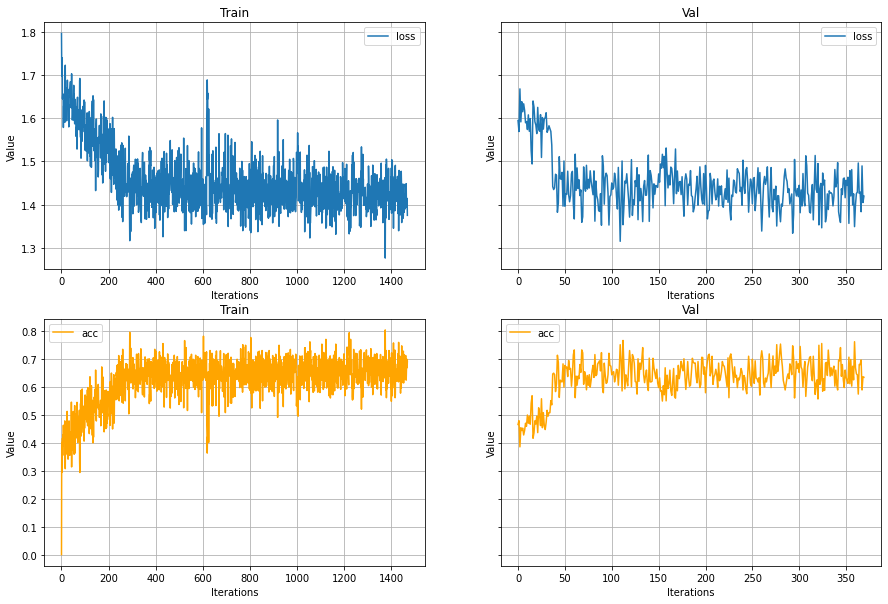

In [ ]:
plot_training(*out)

Ура она обучается!

Теперь сделаем эксперименты. Повторять за статьей смысла нет, т.к. экспериментов много, но данные у нас другие, так что сделаем свои. 

Сначала посмотрим на влияние количества и размера сверток:

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5850751481088652, Train metric: 0.4887019991874695
Val loss: 1.5320065021514893, Val metric: 0.5500925183296204
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.53403606057978, Train metric: 0.544914960861206
Val loss: 1.5273986152700476, Val metric: 0.5493869185447693
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5298189086978937, Train metric: 0.5489399433135986
Val loss: 1.5241739975439537, Val metric: 0.5561468601226807
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5274003314323166, Train metric: 0.5523516535758972
Val loss: 1.5322139069840714, Val metric: 0.5475807189941406
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5229634979144246, Train metric: 0.5557127594947815
Val loss: 1.5964015432306238, Val metric: 0.45740771293640137
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.6222746972324087, Train metric: 0.45170262455940247
Val loss: 1.6564025621156435, Val metric: 0.414

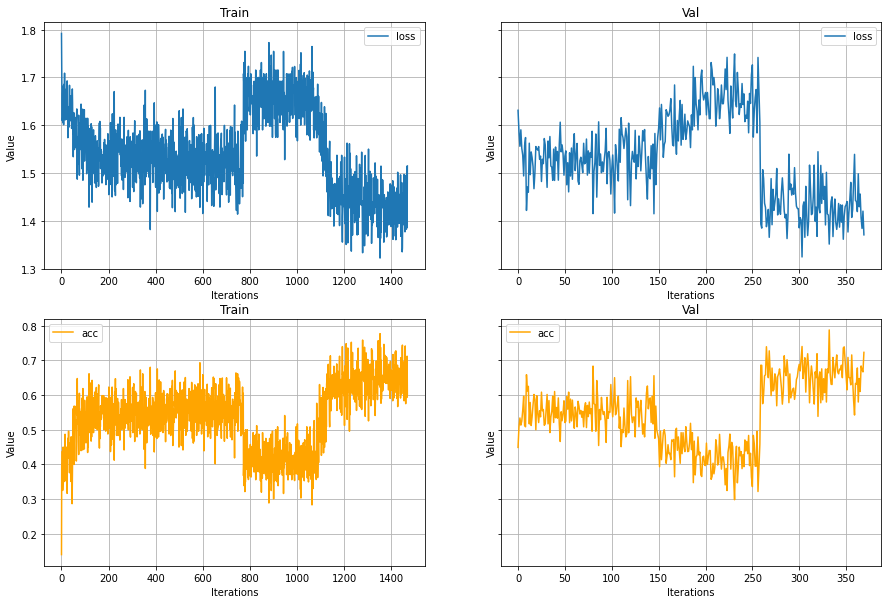

{'filter_sizes': [3], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.6001535670286944, Train metric: 0.46903419494628906
Val loss: 1.531606310122722, Val metric: 0.5538608431816101
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5315555171901678, Train metric: 0.5487642884254456
Val loss: 1.5187520658647693, Val metric: 0.559296727180481
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.510328003338405, Train metric: 0.5709670186042786
Val loss: 1.4654358271005992, Val metric: 0.6215561628341675
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4551027031982837, Train metric: 0.6287826299667358
Val loss: 1.443289511912578, Val metric: 0.6407476663589478
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4353840594389, Train metric: 0.6485773324966431
Val loss: 1.4472871857720453, Val metric: 0.6320897936820984
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4334810493754693, Train metric: 0.6500838994979858
Val loss: 1.4247427824381236, Val metric: 0.65976881

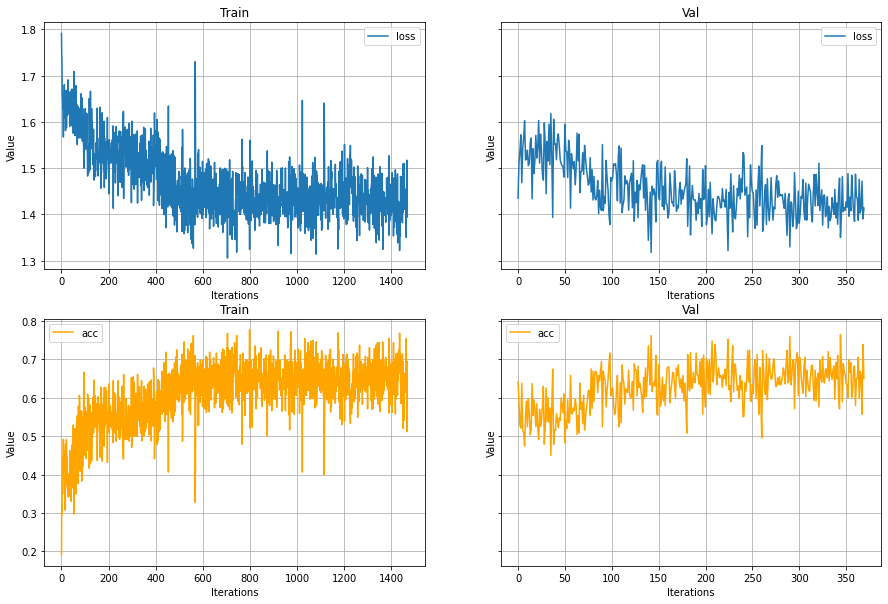

{'filter_sizes': [4], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.595996576912549, Train metric: 0.4769233763217926
Val loss: 1.5409517030458193, Val metric: 0.5470879673957825
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5331477380934215, Train metric: 0.5467616319656372
Val loss: 1.5304532566586055, Val metric: 0.5514000654220581
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.529080672328975, Train metric: 0.5492273569107056
Val loss: 1.519106294657733, Val metric: 0.5598475337028503
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5211117300046544, Train metric: 0.558336615562439
Val loss: 1.5149713110279392, Val metric: 0.5669221878051758
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5162879220482444, Train metric: 0.5624753832817078
Val loss: 1.5179732039168075, Val metric: 0.5553385019302368
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.5117522251038324, Train metric: 0.5677148103713989
Val loss: 1.474777102470398, Val metric: 0.6075116

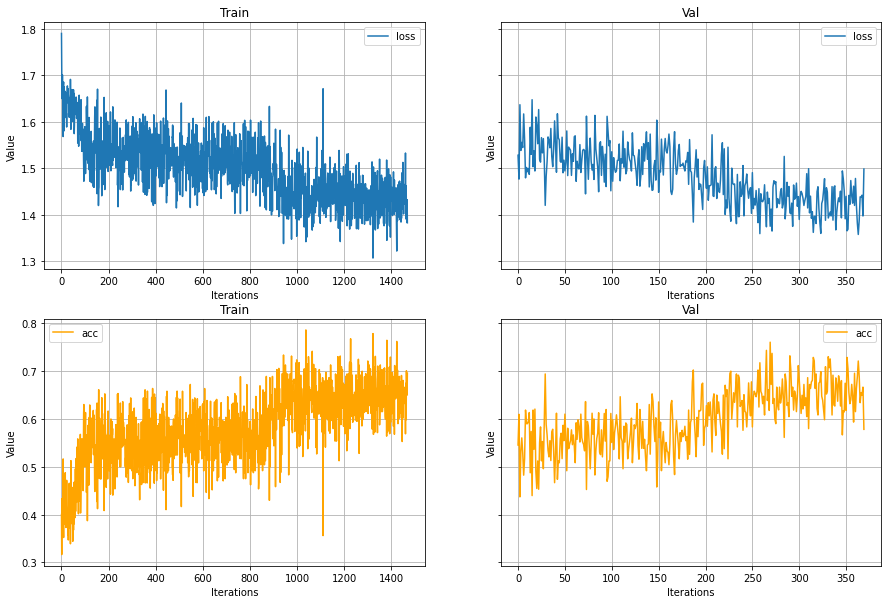

{'filter_sizes': [2, 3], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.6033728974206107, Train metric: 0.4718771278858185
Val loss: 1.4603209817731702, Val metric: 0.6395037770271301
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.4488923663184756, Train metric: 0.6373734474182129
Val loss: 1.4359966677588385, Val metric: 0.6471286416053772
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4463654553809133, Train metric: 0.6384299397468567
Val loss: 1.4479163144085858, Val metric: 0.6389129161834717
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4346693600116134, Train metric: 0.6496642231941223
Val loss: 1.4277483257087502, Val metric: 0.6564225554466248
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4350232267055383, Train metric: 0.6486026644706726
Val loss: 1.443065807626054, Val metric: 0.6417762041091919
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4348669611677831, Train metric: 0.648602306842804
Val loss: 1.4452974764076438, Val metric: 0.6412

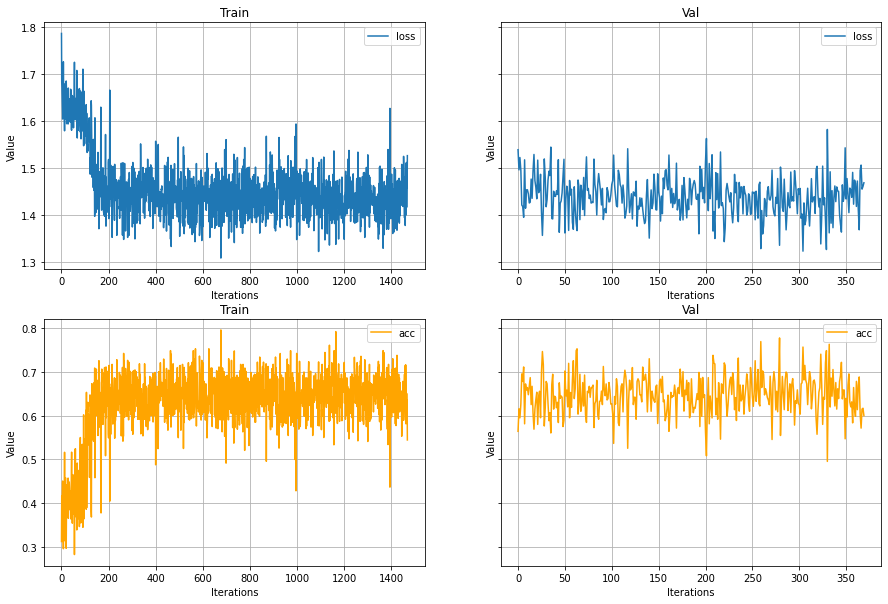

{'filter_sizes': [3, 4], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5802574068510613, Train metric: 0.4997497797012329
Val loss: 1.4800986309309263, Val metric: 0.6114752888679504
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.44628001719105, Train metric: 0.6393671035766602
Val loss: 1.4411332736144196, Val metric: 0.64496248960495
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4368055272264546, Train metric: 0.6482588648796082
Val loss: 1.4418808930629008, Val metric: 0.641419529914856
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4401800413520969, Train metric: 0.643695056438446
Val loss: 1.4470842110144126, Val metric: 0.6387086510658264
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4457569600773506, Train metric: 0.6369590759277344
Val loss: 1.4528716899253227, Val metric: 0.6328238844871521
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4491522547339095, Train metric: 0.6367859840393066
Val loss: 1.445735361125018, Val metric: 0.640927076

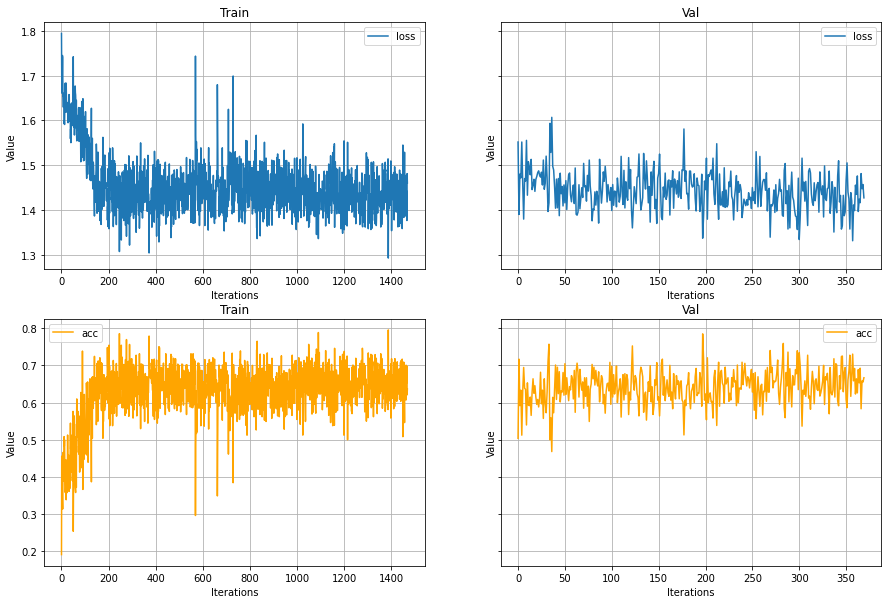

{'filter_sizes': [2, 4], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5975039443191217, Train metric: 0.4715884327888489
Val loss: 1.5525078612404901, Val metric: 0.5320565104484558
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5401264493968212, Train metric: 0.5398903489112854
Val loss: 1.5199747343321104, Val metric: 0.56181401014328
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.526613012463057, Train metric: 0.5529320240020752
Val loss: 1.5172633158194053, Val metric: 0.5648099184036255
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5241195831169077, Train metric: 0.5552915334701538
Val loss: 1.5178138855341319, Val metric: 0.5633510947227478
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5411246787934076, Train metric: 0.537108302116394
Val loss: 1.6555508407386574, Val metric: 0.4161231815814972
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.614545775108597, Train metric: 0.45858234167099
Val loss: 1.5116886126028526, Val metric: 0.575130879

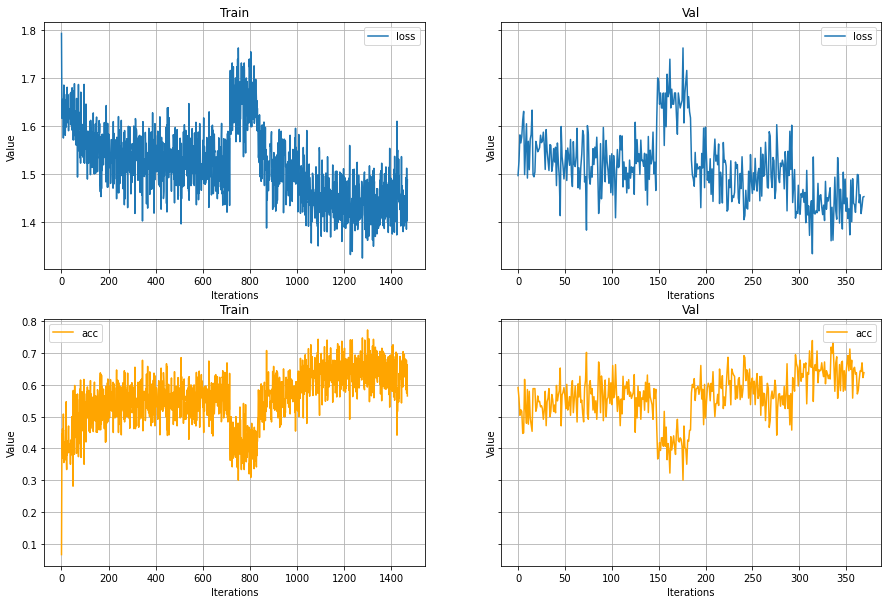

{'filter_sizes': [2, 3, 4], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.6189310177653826, Train metric: 0.44373175501823425
Val loss: 1.602904741828506, Val metric: 0.4680922329425812
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5221557730720157, Train metric: 0.561336100101471
Val loss: 1.4555582581339657, Val metric: 0.629287600517273
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4519463161221977, Train metric: 0.6329666972160339
Val loss: 1.438753437351536, Val metric: 0.6472339034080505
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4897491899477382, Train metric: 0.5917254686355591
Val loss: 1.4312004881936151, Val metric: 0.6531598567962646
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4536275198670472, Train metric: 0.6280001401901245
Val loss: 1.4261713221266463, Val metric: 0.6582949161529541
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4373367497710143, Train metric: 0.6455096006393433
Val loss: 1.424114997322495, Val metric: 0.659848

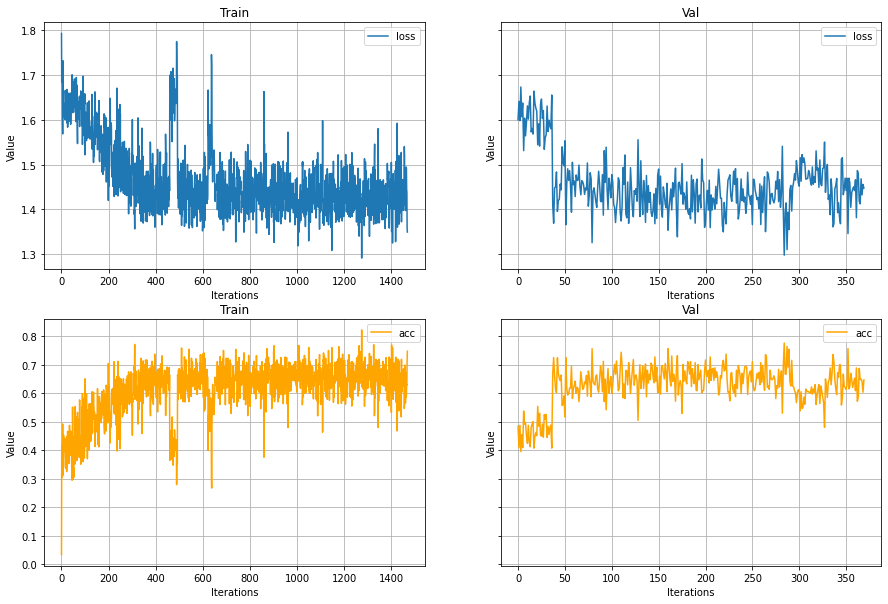

In [ ]:
results = []
for filter_sizes in [[2], [3], [4], [2, 3], [3, 4], [2, 4], [2, 3, 4]]:
    num_filters = 150 
    memory_dim = 150 
    lstm_layers = 1 
    dropout_layer = ['emb'] 
    model = CLSTM(len(word2id),
                  num_filters=num_filters,
                  memory_dim=memory_dim,
                  lstm_layers=lstm_layers, 
                  dropout_layer=dropout_layer,
                  filter_sizes=filter_sizes)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()
    
    print({'filter_sizes': filter_sizes,
            'num_filters': num_filters,
            'memory_dim': memory_dim,
            'lstm_layers': lstm_layers,
            'dropout_layer': dropout_layer})
    
    out = train(train_iterator,
                val_iterator,
                model,
                optimizer,
                criterion,
                epochs=10,
                metric=accuracy)

    results.append({'filter_sizes': filter_sizes,
                    'num_filters': num_filters,
                    'memory_dim': memory_dim,
                    'lstm_layers': lstm_layers,
                    'dropout_layer': dropout_layer,
                    'accuracy': out[-1]})

    plot_training(*out)
    plt.show()

In [ ]:
sorted(results, key=lambda x: x['accuracy'], reverse=True)[0]

{'filter_sizes': [2],
 'num_filters': 150,
 'memory_dim': 150,
 'lstm_layers': 1,
 'dropout_layer': ['emb'],
 'accuracy': 0.66103613}

Как видим, модель с такими дефолтными параметрами лучше всего работает с одиним сверточным слоем и размером свертки 2. В остальных случаях видим, что лосс местами скачет странно + видим переобучение

Теперь посмотрим на влияние количества фильтров: 

{'filter_sizes': [2], 'num_filters': 100, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.594402739790832, Train metric: 0.477804571390152
Val loss: 1.548918063576157, Val metric: 0.5352603197097778
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5340609582913975, Train metric: 0.5454416871070862
Val loss: 1.5335530364835583, Val metric: 0.5467081069946289
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5324874281072292, Train metric: 0.5461697578430176
Val loss: 1.53553467505687, Val metric: 0.5503340363502502
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.528869941121056, Train metric: 0.5497266054153442
Val loss: 1.5210010650995616, Val metric: 0.5592814683914185
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5206850377880796, Train metric: 0.5592313408851624
Val loss: 1.5105184058885317, Val metric: 0.569573700428009
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4819626718962273, Train metric: 0.6002723574638367
Val loss: 1.445702836320207, Val metric: 0.6402340531

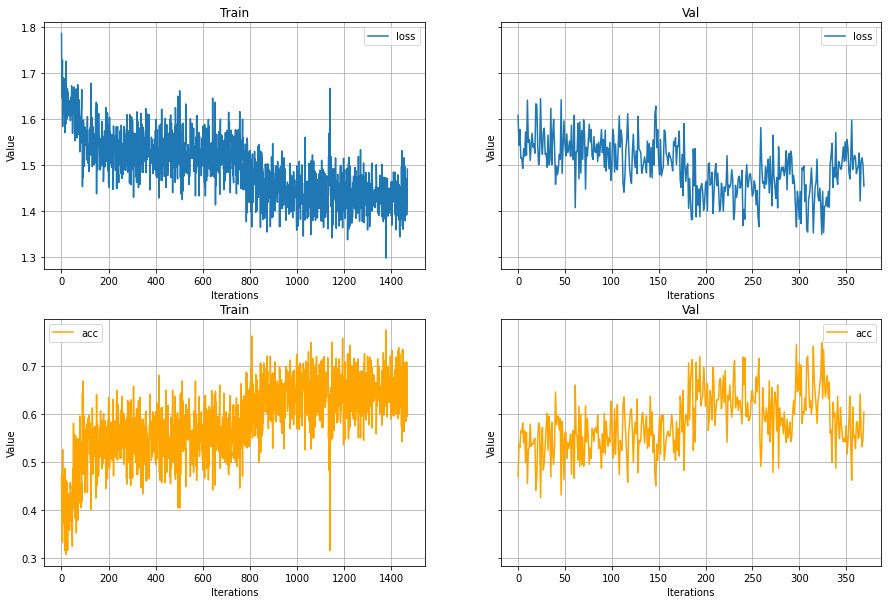

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.6027656258368979, Train metric: 0.4626820981502533
Val loss: 1.5360880478008374, Val metric: 0.5466386675834656
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5352239592545698, Train metric: 0.54352867603302
Val loss: 1.529973332946365, Val metric: 0.5482285022735596
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5293402517733932, Train metric: 0.5497782230377197
Val loss: 1.5241005324028634, Val metric: 0.5573791861534119
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5292502495707299, Train metric: 0.5497367978096008
Val loss: 1.5228748192658295, Val metric: 0.5579564571380615
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5247096342294395, Train metric: 0.5553993582725525
Val loss: 1.515079901025102, Val metric: 0.5650457143783569
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.5223060197570697, Train metric: 0.5578358769416809
Val loss: 1.5096939608857438, Val metric: 0.570824

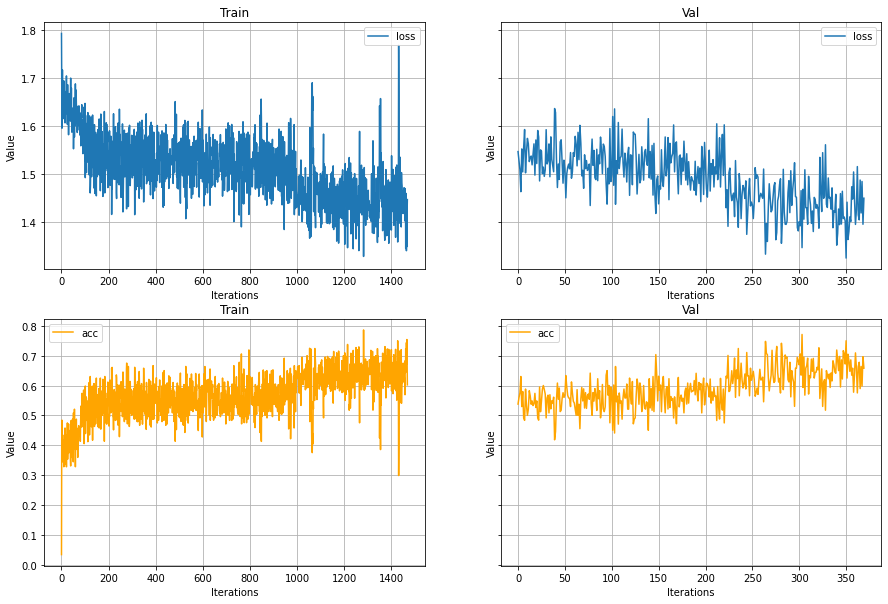

{'filter_sizes': [2], 'num_filters': 300, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5893742762455323, Train metric: 0.48517993092536926
Val loss: 1.4854507639601424, Val metric: 0.6088538765907288
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.4675589832318883, Train metric: 0.6195223927497864
Val loss: 1.4482366974289353, Val metric: 0.6376827359199524
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4462468753866597, Train metric: 0.6374823451042175
Val loss: 1.4296548849827535, Val metric: 0.6556333303451538
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4368584277678509, Train metric: 0.6466550230979919
Val loss: 1.4291675477414518, Val metric: 0.654740035533905
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4320659313072153, Train metric: 0.6509490609169006
Val loss: 1.4248653650283813, Val metric: 0.6585307717323303
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4453465898020739, Train metric: 0.6374422907829285
Val loss: 1.433697069013441, Val metric: 0.647

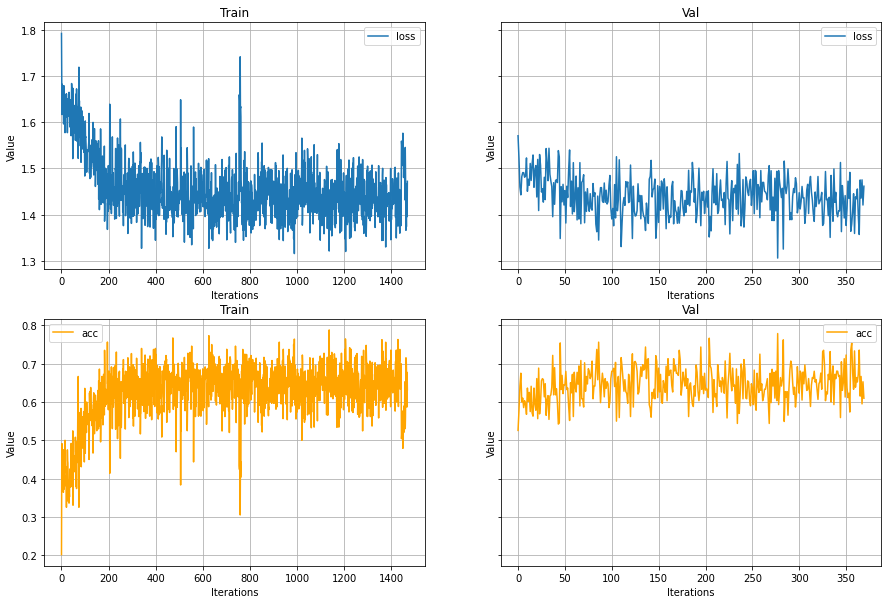

In [ ]:
for num_filters in [100, 150, 300]:
    filter_sizes = [2]
    memory_dim = 150 
    lstm_layers = 1  
    dropout_layer = ['emb'] 
    model = CLSTM(len(word2id),
                  num_filters=num_filters,
                  memory_dim=memory_dim,
                  lstm_layers=lstm_layers, 
                  dropout_layer=dropout_layer,
                  filter_sizes=filter_sizes)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()
    
    print({'filter_sizes': filter_sizes,
            'num_filters': num_filters,
            'memory_dim': memory_dim,
            'lstm_layers': lstm_layers,
            'dropout_layer': dropout_layer})
    
    out = train(train_iterator,
                val_iterator,
                model,
                optimizer,
                criterion,
                epochs=10,
                metric=accuracy)

    results.append({'filter_sizes': filter_sizes,
                    'num_filters': num_filters,
                    'memory_dim': memory_dim,
                    'lstm_layers': lstm_layers,
                    'dropout_layer': dropout_layer,
                    'accuracy': out[-1]})

    plot_training(*out)
    plt.show()

In [ ]:
sorted(results, key=lambda x: x['accuracy'], reverse=True)[0]

{'filter_sizes': [2],
 'num_filters': 150,
 'memory_dim': 150,
 'lstm_layers': 1,
 'dropout_layer': ['emb'],
 'accuracy': 0.6620816}

Здесь видим: 
- с маленьким количеством фильтров модель недообучается
- с большим количеством фильтров модель уходит в плато

Посмотрим на размер внутреннего слоя LSTM:

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 100, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5752210933334974, Train metric: 0.5000212788581848
Val loss: 1.5279575457444061, Val metric: 0.5489692687988281
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5298595120306728, Train metric: 0.5494815111160278
Val loss: 1.520836072999078, Val metric: 0.5613985061645508
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5244890719043964, Train metric: 0.5546430349349976
Val loss: 1.5758130034884892, Val metric: 0.47937026619911194
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5196753991704408, Train metric: 0.5602291226387024
Val loss: 1.5129643549790253, Val metric: 0.5651001930236816
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.464554068993549, Train metric: 0.6179636716842651
Val loss: 1.4441373251579903, Val metric: 0.6352113485336304
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.435300432905859, Train metric: 0.6483068466186523
Val loss: 1.430553184973227, Val metric: 0.65444

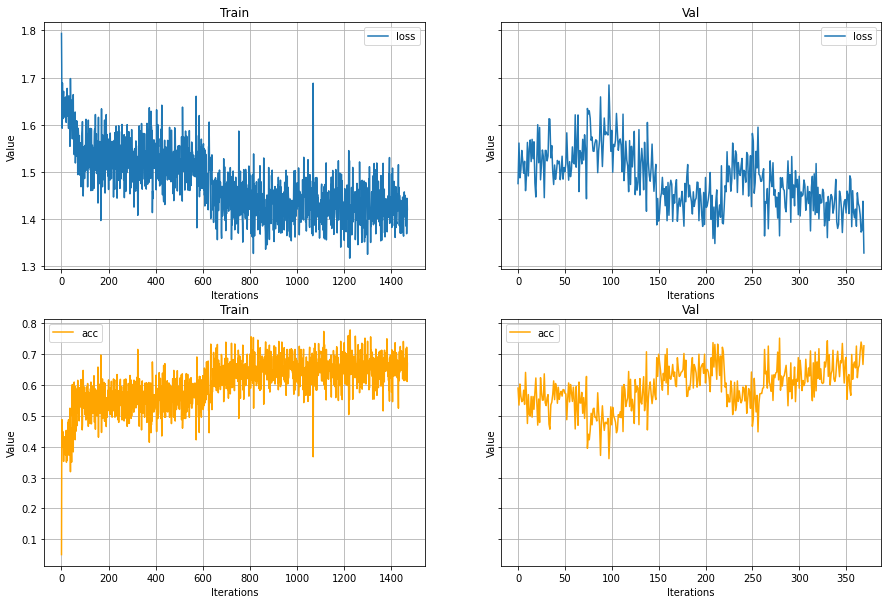

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.6030106552604104, Train metric: 0.467010498046875
Val loss: 1.5408924270320583, Val metric: 0.5409725904464722
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5363165083385648, Train metric: 0.5430676937103271
Val loss: 1.5329143227757633, Val metric: 0.5478575229644775
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5290746510434312, Train metric: 0.5501667261123657
Val loss: 1.5249823525145247, Val metric: 0.5535722970962524
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.521043263325075, Train metric: 0.5584623217582703
Val loss: 1.477881231823483, Val metric: 0.6084121465682983
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4614840226919472, Train metric: 0.6204921007156372
Val loss: 1.4479255611832078, Val metric: 0.6378389000892639
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4414223067614498, Train metric: 0.640655517578125
Val loss: 1.4314395511472546, Val metric: 0.650748

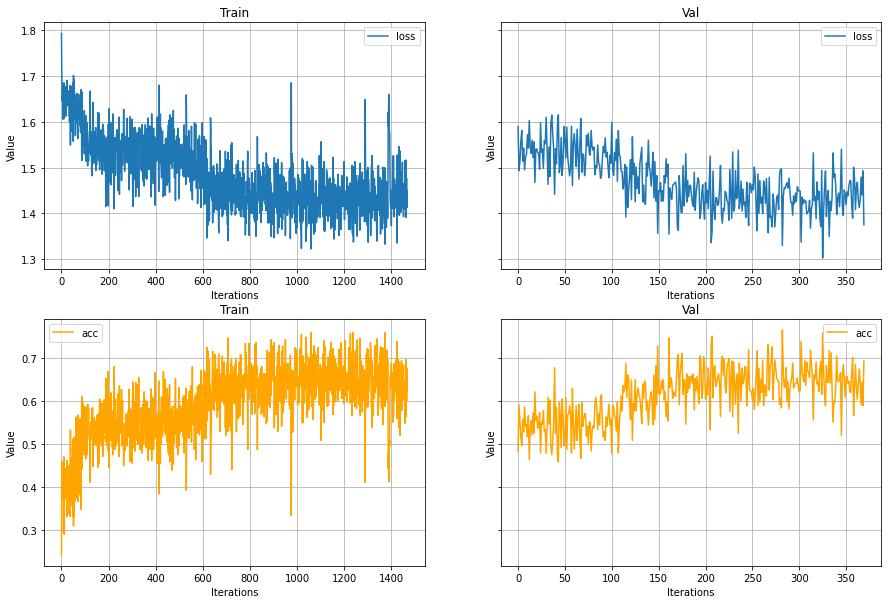

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 300, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5980697651298679, Train metric: 0.4712145924568176
Val loss: 1.5643263217565175, Val metric: 0.49673956632614136
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5401344648023851, Train metric: 0.537600576877594
Val loss: 1.553540149250546, Val metric: 0.5244569778442383
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5313180328226415, Train metric: 0.5482438206672668
Val loss: 1.5267893140380446, Val metric: 0.5532559156417847
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5293105329786028, Train metric: 0.5497486591339111
Val loss: 1.5359186546222583, Val metric: 0.5435373783111572
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5273218876650545, Train metric: 0.5519709587097168
Val loss: 1.523802087113664, Val metric: 0.556192934513092
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.5267306347282565, Train metric: 0.551196277141571
Val loss: 1.5222480490400985, Val metric: 0.556623

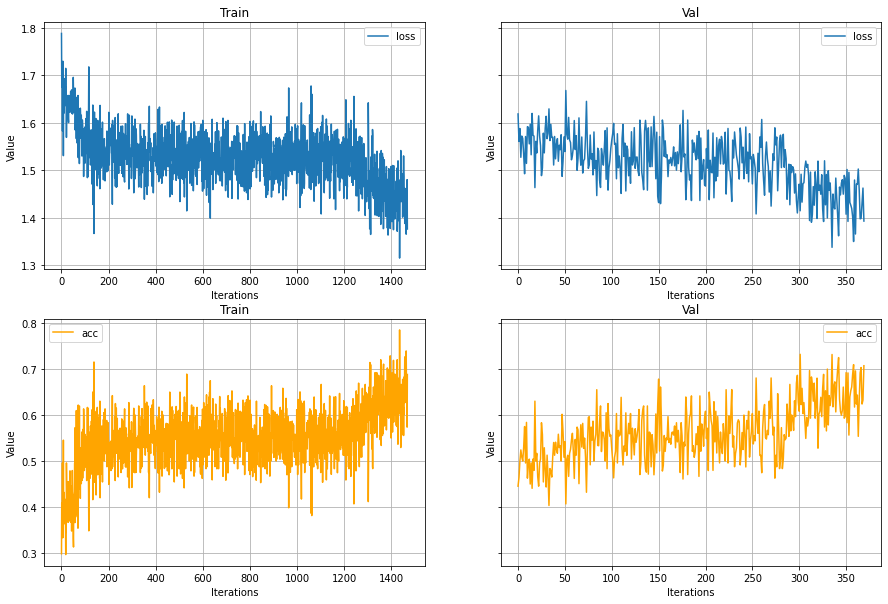

In [ ]:
for memory_dim  in [100, 150, 300]:
    num_filters = 150
    filter_sizes = [2]
    lstm_layers = 1 
    dropout_layer = ['emb']
    model = CLSTM(len(word2id),
                  num_filters=num_filters,
                  memory_dim=memory_dim,
                  lstm_layers=lstm_layers, 
                  dropout_layer=dropout_layer,
                  filter_sizes=filter_sizes)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()
    
    print({'filter_sizes': filter_sizes,
            'num_filters': num_filters,
            'memory_dim': memory_dim,
            'lstm_layers': lstm_layers,
            'dropout_layer': dropout_layer})
    
    out = train(train_iterator,
                val_iterator,
                model,
                optimizer,
                criterion,
                epochs=10,
                metric=accuracy)

    results.append({'filter_sizes': filter_sizes,
                    'num_filters': num_filters,
                    'memory_dim': memory_dim,
                    'lstm_layers': lstm_layers,
                    'dropout_layer': dropout_layer,
                    'accuracy': out[-1]})

    plot_training(*out)
    plt.show()

In [ ]:
sorted(results, key=lambda x: x['accuracy'], reverse=True)[0]

{'filter_sizes': [2],
 'num_filters': 150,
 'memory_dim': 150,
 'lstm_layers': 1,
 'dropout_layer': ['emb'],
 'accuracy': 0.6620816}

Здесь видим, что 
- с размерностью 100 получаем лучшее качество, но там лосс выдает странные скачки, надо думать над lr 
- c размерностью большей 150 сначала как будто уходим в плато, а потом резко лосс уменьшается
- с размерностью 100 все стабильно падает 

Теперь посмотрим на место дропаута:

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5758603048973343, Train metric: 0.5020871162414551
Val loss: 1.5289786184156262, Val metric: 0.5547834634780884
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5333576583537927, Train metric: 0.5462965965270996
Val loss: 1.5459662836951178, Val metric: 0.5285174250602722
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5274734691697724, Train metric: 0.5510950684547424
Val loss: 1.5213773733860738, Val metric: 0.5553414821624756
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5218837163886245, Train metric: 0.5572070479393005
Val loss: 1.5315185237575222, Val metric: 0.5464456081390381
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4832849972913054, Train metric: 0.5994089245796204
Val loss: 1.4588426415984694, Val metric: 0.6189739108085632
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4471943256806354, Train metric: 0.63601154088974
Val loss: 1.4392250679634713, Val metric: 0.6440

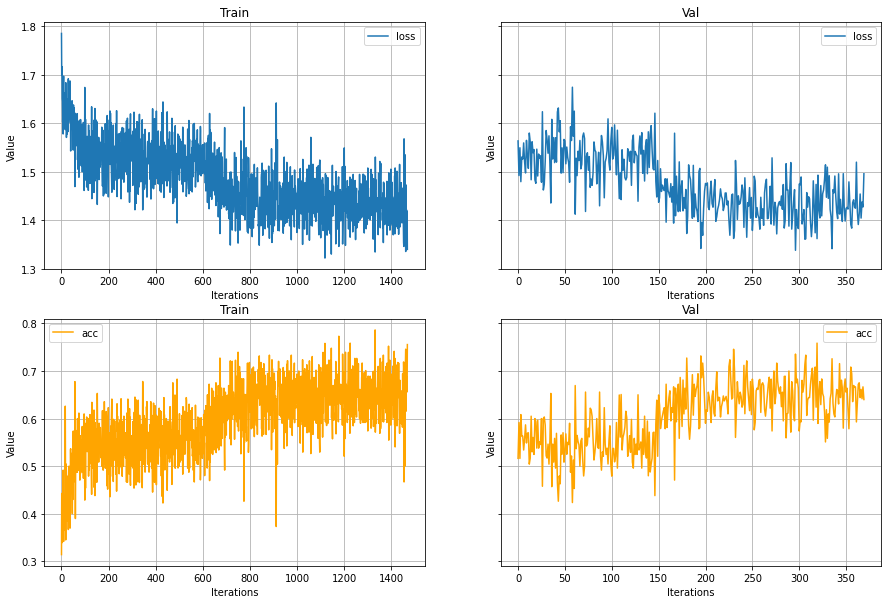

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['lstm']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5740040994825817, Train metric: 0.5039253234863281
Val loss: 1.5373497814745516, Val metric: 0.5438881516456604
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.532560149828593, Train metric: 0.5469791889190674
Val loss: 1.5413923038018715, Val metric: 0.5319212079048157
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5283982210418805, Train metric: 0.5520821809768677
Val loss: 1.559575103424691, Val metric: 0.5135206580162048
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5029598717786827, Train metric: 0.5795430541038513
Val loss: 1.5020828665913761, Val metric: 0.5982166528701782
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4455558613044064, Train metric: 0.6374567747116089
Val loss: 1.4357709336925197, Val metric: 0.6467629075050354
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4415463330794354, Train metric: 0.6433374881744385
Val loss: 1.428428823883469, Val metric: 0.65574

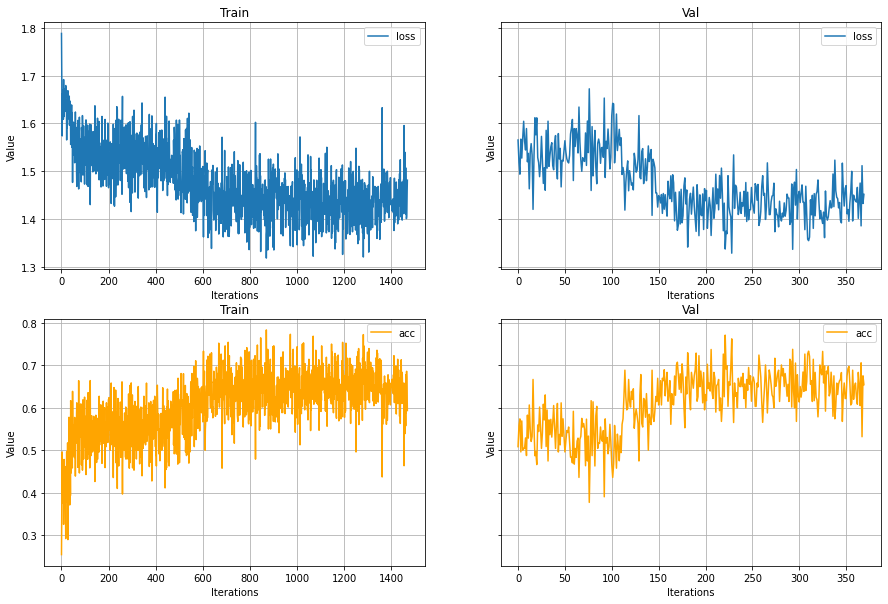

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb', 'lstm']}
Training...


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.6039138691765922, Train metric: 0.45874926447868347
Val loss: 1.5353628848050092, Val metric: 0.5399790406227112
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5339227906700705, Train metric: 0.5452131032943726
Val loss: 1.5250787896078986, Val metric: 0.5561189651489258
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5285720752210032, Train metric: 0.5503377318382263
Val loss: 1.528957173630998, Val metric: 0.55889892578125
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5254563814928743, Train metric: 0.5536657571792603
Val loss: 1.516761022645074, Val metric: 0.559766948223114
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5208659309919188, Train metric: 0.5577483177185059
Val loss: 1.500111940744761, Val metric: 0.5820413827896118
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4744053689800962, Train metric: 0.6068339943885803
Val loss: 1.4384102982443732, Val metric: 0.6476246

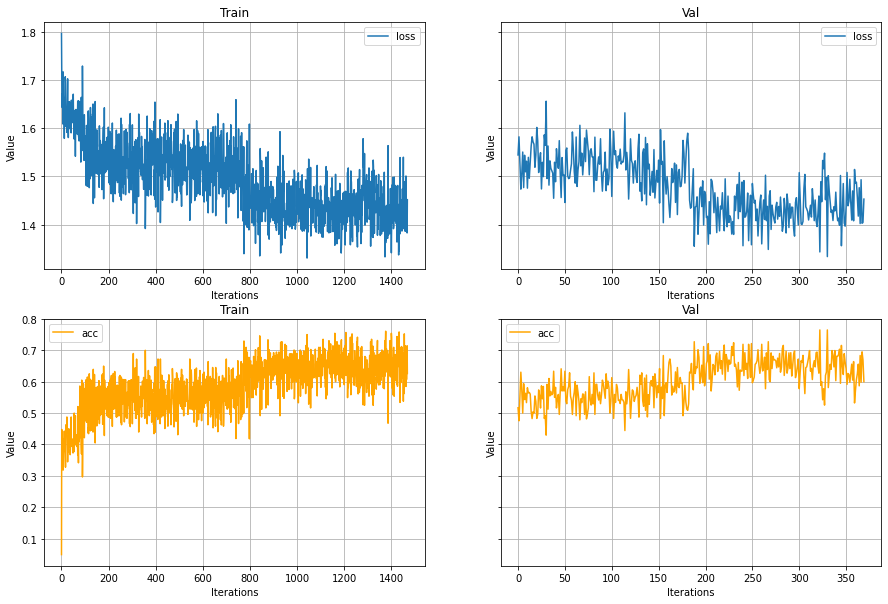

In [ ]:
for dropout_layer in [['emb'], ['lstm'],['emb', 'lstm']]:
    num_filters = 150
    filter_sizes = [2]
    lstm_layers = 1 
    memory_dim = 150
    model = CLSTM(len(word2id),
                  num_filters=num_filters,
                  memory_dim=memory_dim,
                  lstm_layers=lstm_layers, 
                  dropout_layer=dropout_layer,
                  filter_sizes=filter_sizes)
    optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
    criterion = nn.CrossEntropyLoss()
    
    print({'filter_sizes': filter_sizes,
            'num_filters': num_filters,
            'memory_dim': memory_dim,
            'lstm_layers': lstm_layers,
            'dropout_layer': dropout_layer})
    
    out = train(train_iterator,
                val_iterator,
                model,
                optimizer,
                criterion,
                epochs=10,
                metric=accuracy)

    results.append({'filter_sizes': filter_sizes,
                    'num_filters': num_filters,
                    'memory_dim': memory_dim,
                    'lstm_layers': lstm_layers,
                    'dropout_layer': dropout_layer,
                    'accuracy': out[-1]})

    plot_training(*out)
    plt.show()

In [ ]:
sorted(results, key=lambda x: x['accuracy'], reverse=True)[0]

{'filter_sizes': [2],
 'num_filters': 150,
 'memory_dim': 150,
 'lstm_layers': 1,
 'dropout_layer': ['emb'],
 'accuracy': 0.6620816}

Тут сильной разницы нет

Теперь когда мы немного познакомились с поведением модели, двавайте посмотрим на несколько вариантов сочетания гиперпараметров (это в основном вещи из статьи и некоторые дополнения)

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 100, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5902813478391997, Train metric: 0.47868746519088745
Val loss: 1.516831575213252, Val metric: 0.5655165910720825
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5255263265298338, Train metric: 0.5546913146972656
Val loss: 1.5060554098438572, Val metric: 0.5770607590675354
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5156599242671007, Train metric: 0.5653003454208374
Val loss: 1.488081007390409, Val metric: 0.5930966138839722
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4526579655757568, Train metric: 0.6319060325622559
Val loss: 1.4567297632629808, Val metric: 0.619010865688324
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4438662050532647, Train metric: 0.6402645111083984
Val loss: 1.4538040902163532, Val metric: 0.6310051083564758
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4500264537577727, Train metric: 0.6357777714729309
Val loss: 1.438653047020371, Val metric: 0.64354

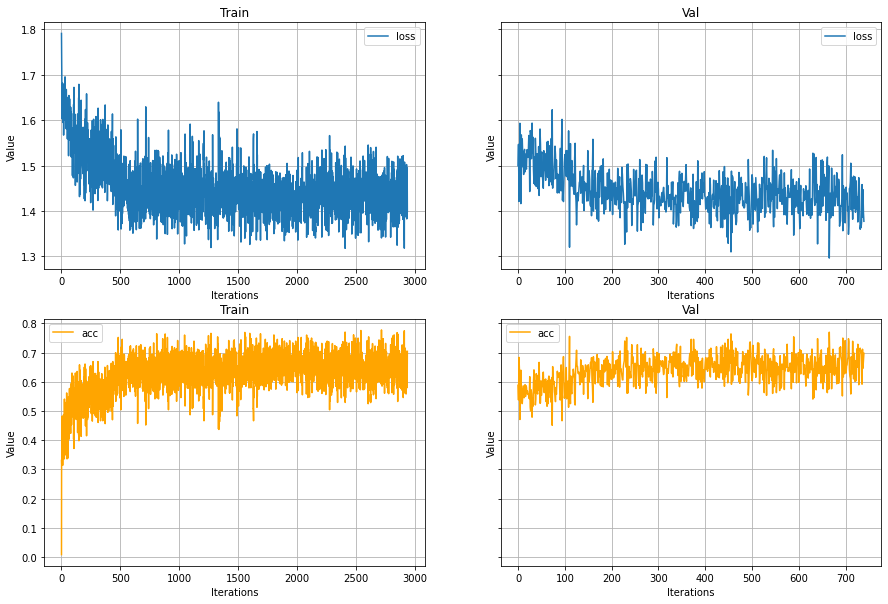

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 100, 'lstm_layers': 1, 'dropout_layer': ['lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5903112588285588, Train metric: 0.475992888212204
Val loss: 1.4521700369345176, Val metric: 0.6351589560508728
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.4418418585848647, Train metric: 0.6435812711715698
Val loss: 1.4423680305480957, Val metric: 0.6435629725456238
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4333448596552116, Train metric: 0.650691568851471
Val loss: 1.4329425418699109, Val metric: 0.6498775482177734
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4515968917989406, Train metric: 0.6307913661003113
Val loss: 1.4270725572431409, Val metric: 0.6587515473365784
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.428707311753513, Train metric: 0.6548482775688171
Val loss: 1.4376678015734699, Val metric: 0.6461300253868103
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4302076774389565, Train metric: 0.6541129350662231
Val loss: 1.4279481591405094, Val metric: 0.65606

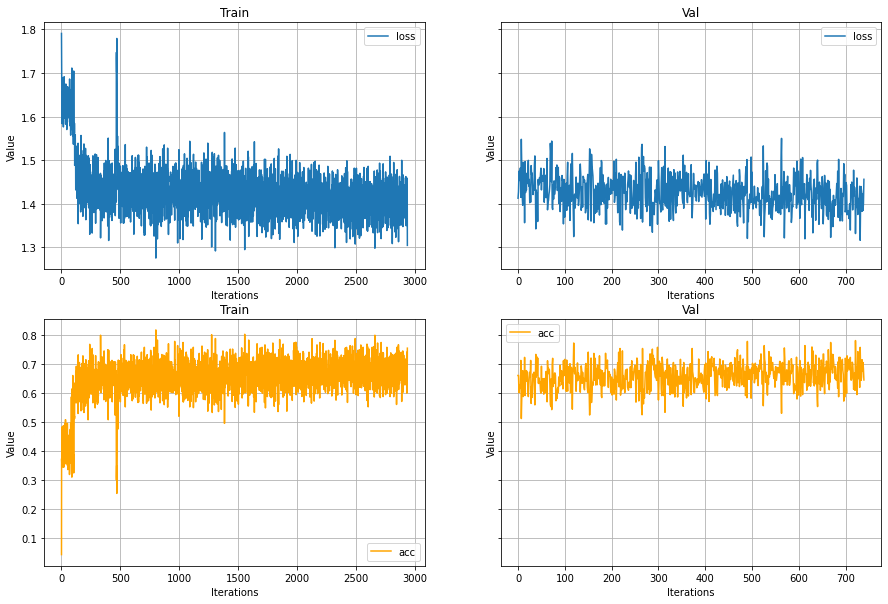

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 100, 'lstm_layers': 1, 'dropout_layer': ['emb', 'lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.57379704024516, Train metric: 0.5071632862091064
Val loss: 1.5207467336912412, Val metric: 0.5567495226860046
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.4970097971611283, Train metric: 0.5858895182609558
Val loss: 1.449812589464961, Val metric: 0.6376405358314514
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4492270289635172, Train metric: 0.6350752711296082
Val loss: 1.4795890241055876, Val metric: 0.5949946045875549
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4381836944696855, Train metric: 0.6458288431167603
Val loss: 1.43706683854799, Val metric: 0.6459982991218567
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4383746904580772, Train metric: 0.6455352902412415
Val loss: 1.4295087827218544, Val metric: 0.6543878316879272
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4332565231388117, Train metric: 0.6510568261146545
Val loss: 1.4272788344202816, Val metric: 0.6583951

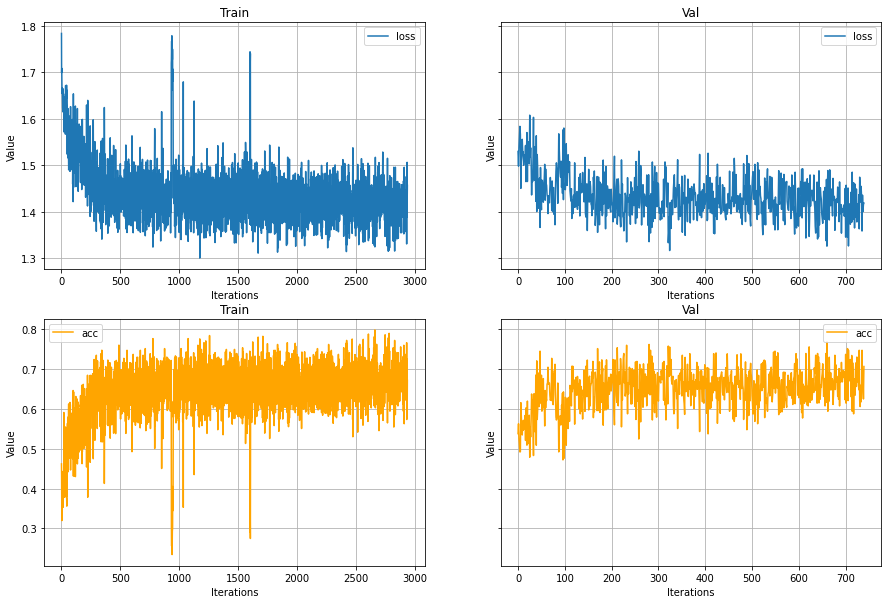

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.575052098352082, Train metric: 0.4986446797847748
Val loss: 1.54819456628851, Val metric: 0.516157329082489
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5352735495080754, Train metric: 0.5443658828735352
Val loss: 1.5313685326962858, Val metric: 0.5468469858169556
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5317888357201401, Train metric: 0.5473894476890564
Val loss: 1.5343052213256423, Val metric: 0.5442336797714233
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5270626950426167, Train metric: 0.5530716180801392
Val loss: 1.5207759464109265, Val metric: 0.5584012269973755
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5089519307726906, Train metric: 0.5729498863220215
Val loss: 1.462269944113654, Val metric: 0.6257578730583191
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4868012317994825, Train metric: 0.5944629907608032
Val loss: 1.454508961857976, Val metric: 0.63077741

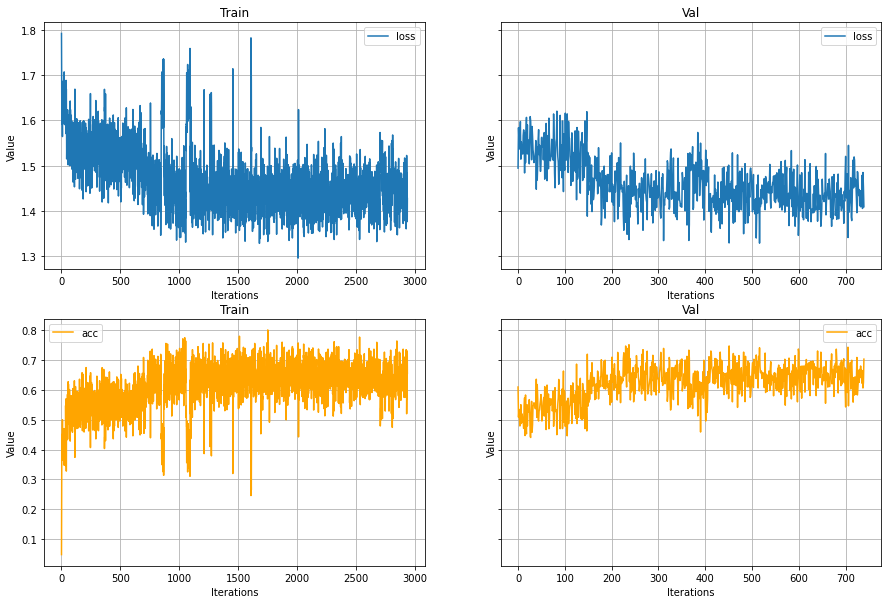

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.58071633017793, Train metric: 0.49439385533332825
Val loss: 1.5293780339730751, Val metric: 0.553085446357727
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5297746747529426, Train metric: 0.5510123372077942
Val loss: 1.5365191150355983, Val metric: 0.5414854884147644
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5264190402971645, Train metric: 0.5526156425476074
Val loss: 1.523612463796461, Val metric: 0.5617353320121765
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5241945844118288, Train metric: 0.5557096600532532
Val loss: 1.5198975801467896, Val metric: 0.5563879609107971
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.52122704512408, Train metric: 0.5576995015144348
Val loss: 1.5122772133028186, Val metric: 0.5657033920288086
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.517240867322805, Train metric: 0.5630858540534973
Val loss: 1.5060909664308704, Val metric: 0.57533514

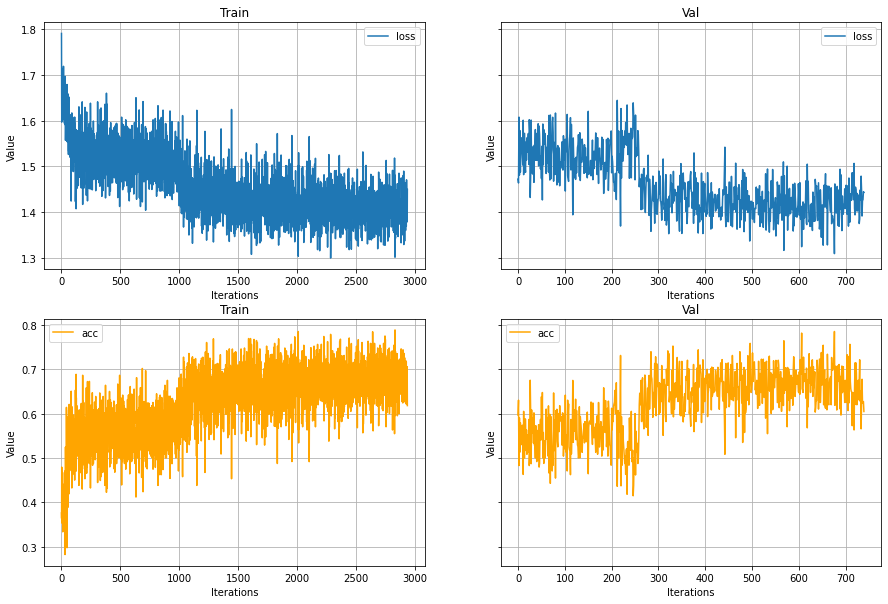

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb', 'lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5742903323400588, Train metric: 0.4981849789619446
Val loss: 1.5414586518261884, Val metric: 0.5360621213912964
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5357230496244365, Train metric: 0.543338418006897
Val loss: 1.5353075716946576, Val metric: 0.5410704016685486
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5289564797667419, Train metric: 0.5505842566490173
Val loss: 1.5261752669875686, Val metric: 0.553744912147522
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5266689508139681, Train metric: 0.5516435503959656
Val loss: 1.5394970114166673, Val metric: 0.530265212059021
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5254022929133202, Train metric: 0.5540218949317932
Val loss: 1.532459072164587, Val metric: 0.5464040637016296
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.5239880814844249, Train metric: 0.5532777905464172
Val loss: 1.5168512576335185, Val metric: 0.561193

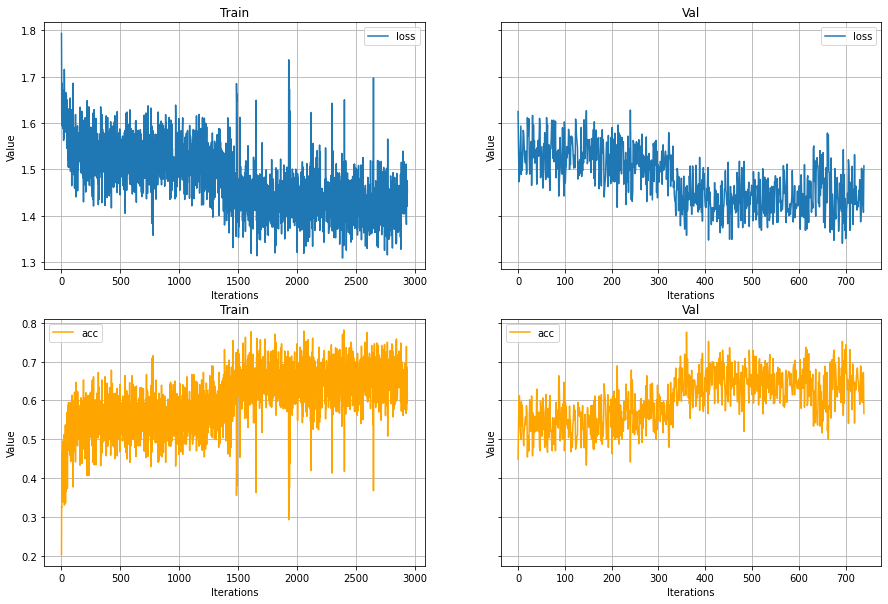

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 300, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.588345229220228, Train metric: 0.4832914173603058
Val loss: 1.5326771381739024, Val metric: 0.5487169027328491
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.536560752764851, Train metric: 0.5417929887771606
Val loss: 1.5333102941513062, Val metric: 0.5451555252075195
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5373791918462636, Train metric: 0.5401608347892761
Val loss: 1.5304991329038464, Val metric: 0.5484247207641602
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5321339547228652, Train metric: 0.5457773804664612
Val loss: 1.528235277614078, Val metric: 0.5479526519775391
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5280778148547323, Train metric: 0.5505641102790833
Val loss: 1.5238298596562565, Val metric: 0.5551149249076843
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.5139086165395723, Train metric: 0.5668031573295593
Val loss: 1.4769314334199235, Val metric: 0.60920

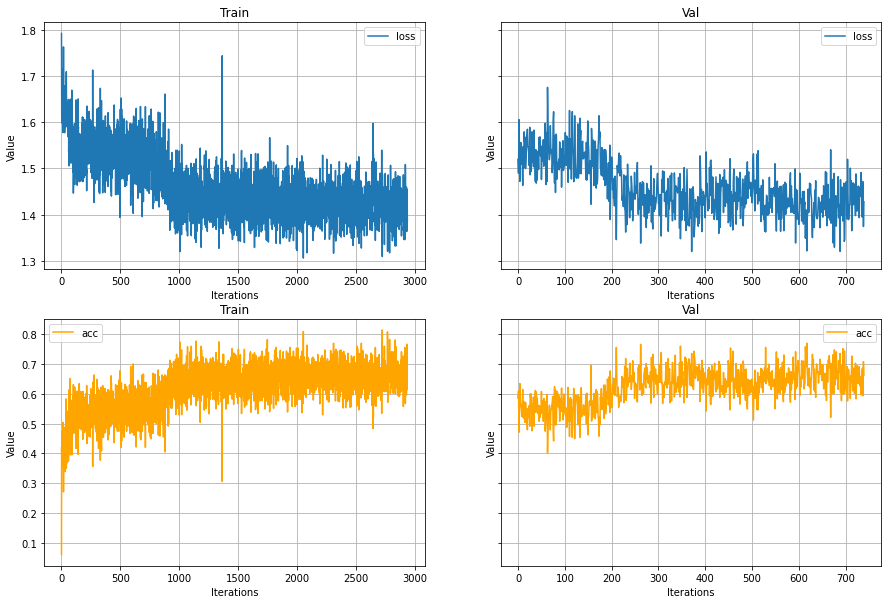

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 300, 'lstm_layers': 1, 'dropout_layer': ['lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.595457326798212, Train metric: 0.4697999060153961
Val loss: 1.5307581875775311, Val metric: 0.5484530329704285
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.534088669180059, Train metric: 0.5447865128517151
Val loss: 1.5343907523799587, Val metric: 0.5446715950965881
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5298173614099724, Train metric: 0.5488243699073792
Val loss: 1.5354659492905076, Val metric: 0.5446637868881226
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.526045358099905, Train metric: 0.5529868006706238
Val loss: 1.5192743604247634, Val metric: 0.5614109635353088
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5239453007574795, Train metric: 0.5545953512191772
Val loss: 1.5234924007106472, Val metric: 0.55483078956604
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.5204007495828227, Train metric: 0.5577545166015625
Val loss: 1.5143272973395683, Val metric: 0.5636297

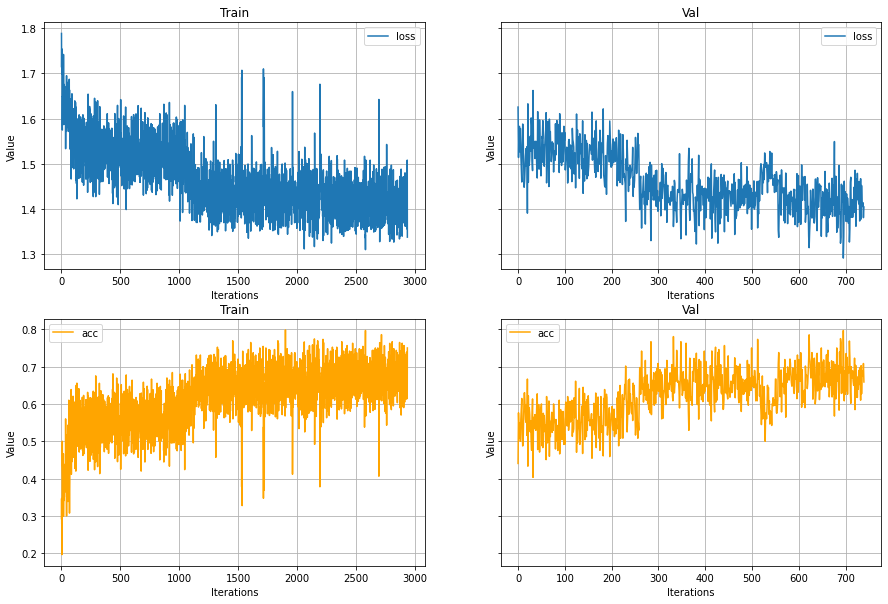

{'filter_sizes': [2], 'num_filters': 150, 'memory_dim': 300, 'lstm_layers': 1, 'dropout_layer': ['emb', 'lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.596876168737606, Train metric: 0.4736204147338867
Val loss: 1.5411956116959855, Val metric: 0.5415686964988708
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.542110503125353, Train metric: 0.5359504222869873
Val loss: 1.5312826440141007, Val metric: 0.5488975644111633
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5361655877560985, Train metric: 0.5420289635658264
Val loss: 1.534285068511963, Val metric: 0.5430507063865662
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5327017112654082, Train metric: 0.5461460947990417
Val loss: 1.5252692892744735, Val metric: 0.5534447431564331
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5287151977318485, Train metric: 0.5508488416671753
Val loss: 1.530236369854695, Val metric: 0.5493581295013428
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.527056521298934, Train metric: 0.552390992641449
Val loss: 1.5330691691991445, Val metric: 0.54511725

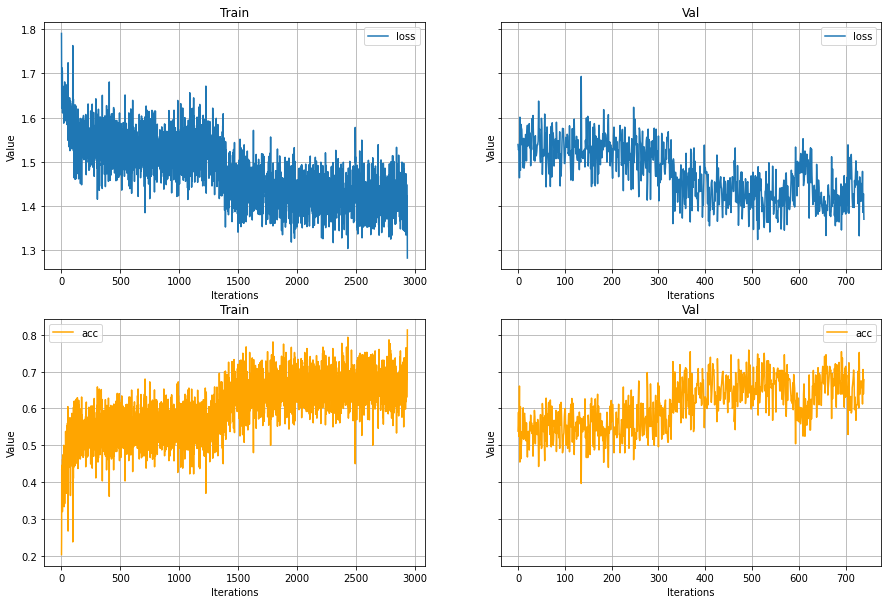

{'filter_sizes': [2, 3, 4], 'num_filters': 150, 'memory_dim': 100, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5954528868603868, Train metric: 0.49397552013397217
Val loss: 1.5089721196406596, Val metric: 0.5967065691947937
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.4665731313277264, Train metric: 0.626032292842865
Val loss: 1.446056604385376, Val metric: 0.6423928141593933
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.439527498621519, Train metric: 0.6458858847618103
Val loss: 1.4387276075981759, Val metric: 0.6462534070014954
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4393286258995939, Train metric: 0.6451831459999084
Val loss: 1.4357489057489343, Val metric: 0.647707462310791
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4325602687135035, Train metric: 0.6518662571907043
Val loss: 1.426086873621554, Val metric: 0.657170832157135
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4304652449225082, Train metric: 0.6535518169403076
Val loss: 1.4334221659479915, Val metric: 0.6497597

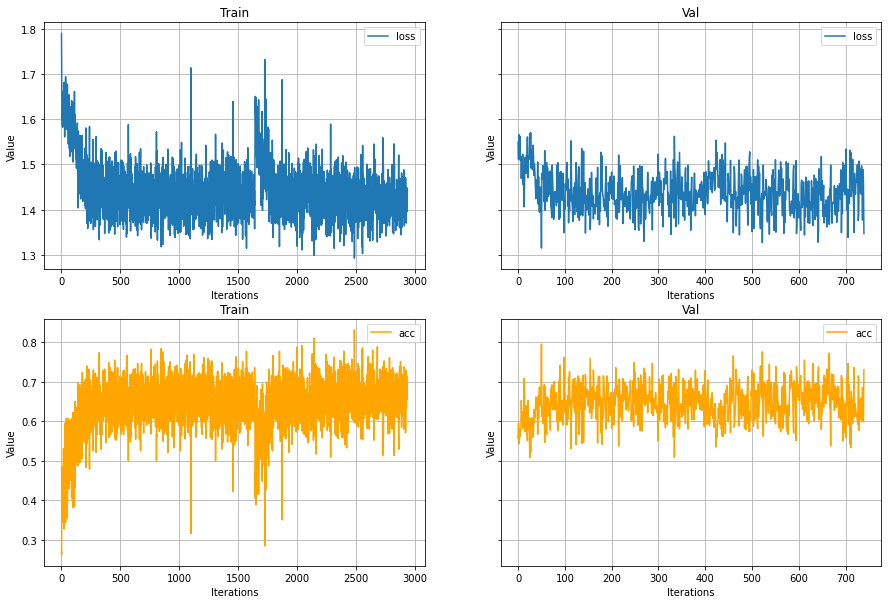

{'filter_sizes': [2, 3, 4], 'num_filters': 150, 'memory_dim': 100, 'lstm_layers': 1, 'dropout_layer': ['lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.553254542707586, Train metric: 0.5323953032493591
Val loss: 1.447324994448069, Val metric: 0.641864001750946
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.4376693469326511, Train metric: 0.6493391990661621
Val loss: 1.4316258462699685, Val metric: 0.6554559469223022
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.430601877420127, Train metric: 0.6545021533966064
Val loss: 1.4291687720530741, Val metric: 0.6533644795417786
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4325178926493847, Train metric: 0.6502558588981628
Val loss: 1.4439020124641624, Val metric: 0.6408992409706116
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4259422693122812, Train metric: 0.6576809883117676
Val loss: 1.421650203498634, Val metric: 0.6626901030540466
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4255618513846884, Train metric: 0.6600870490074158
Val loss: 1.4774795384020418, Val metric: 0.5992864

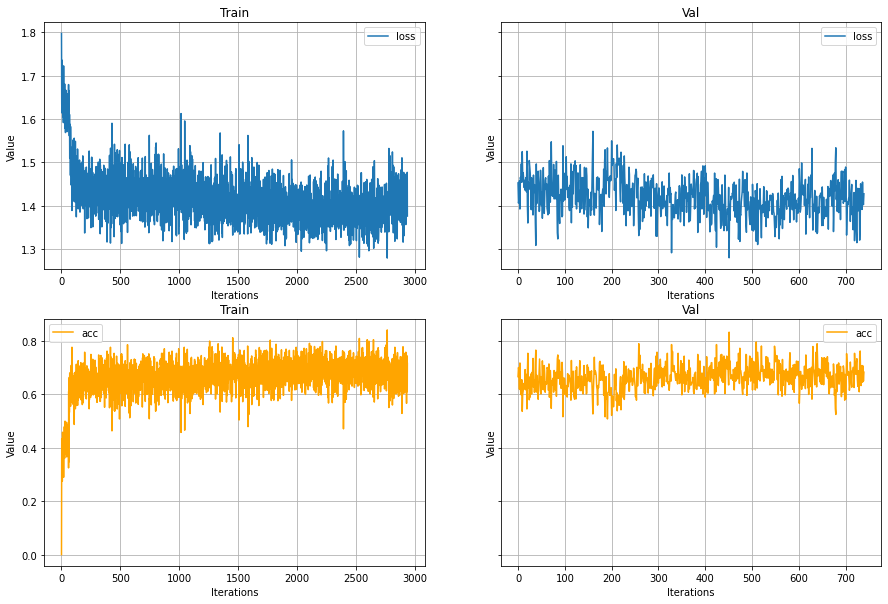

{'filter_sizes': [2, 3, 4], 'num_filters': 150, 'memory_dim': 100, 'lstm_layers': 1, 'dropout_layer': ['emb', 'lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.549517842377124, Train metric: 0.5367217063903809
Val loss: 1.4470824099875785, Val metric: 0.6434339284896851
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.441694594564892, Train metric: 0.6445454955101013
Val loss: 1.4484003395647616, Val metric: 0.6388111710548401
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4328480585902728, Train metric: 0.6523944139480591
Val loss: 1.4512849949501656, Val metric: 0.6338613629341125
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4300323270616078, Train metric: 0.6538937091827393
Val loss: 1.428661607407235, Val metric: 0.6533191204071045
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4348169638186086, Train metric: 0.6492863893508911
Val loss: 1.4470406964018538, Val metric: 0.6347753405570984
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4280096008664085, Train metric: 0.6547366976737976
Val loss: 1.4327124292786058, Val metric: 0.64829

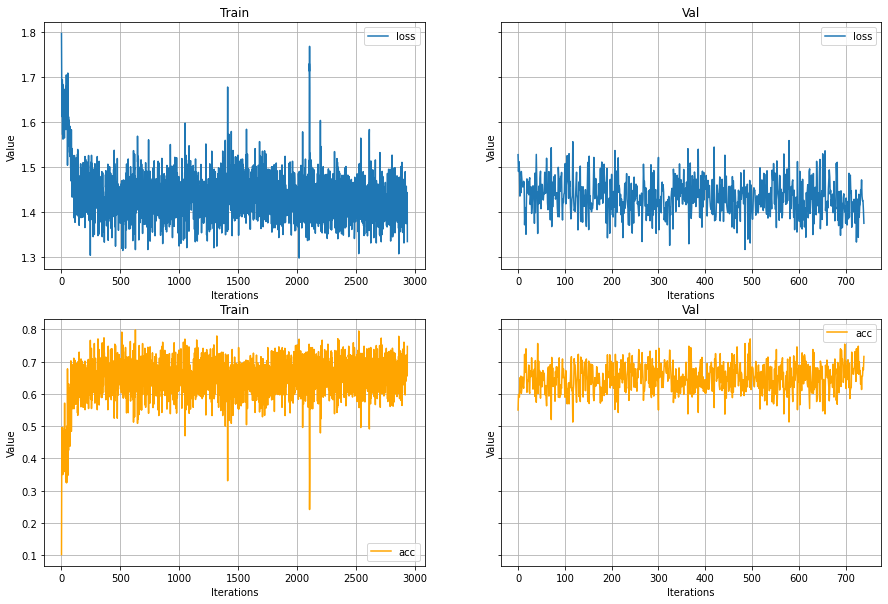

{'filter_sizes': [2, 3, 4], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.6058552029992448, Train metric: 0.46683913469314575
Val loss: 1.5418696629034507, Val metric: 0.5683507323265076
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5021453317330808, Train metric: 0.5850014090538025
Val loss: 1.4532618683737677, Val metric: 0.6343709230422974
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4610742379208, Train metric: 0.621208131313324
Val loss: 1.4421436625557977, Val metric: 0.6426458358764648
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4367605861352415, Train metric: 0.6464817523956299
Val loss: 1.4621428927859745, Val metric: 0.6245640516281128
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.445751930580658, Train metric: 0.6346461772918701
Val loss: 1.4301585893373232, Val metric: 0.654513418674469
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4309504624126719, Train metric: 0.6528235673904419
Val loss: 1.4283749896126825, Val metric: 0.6558614

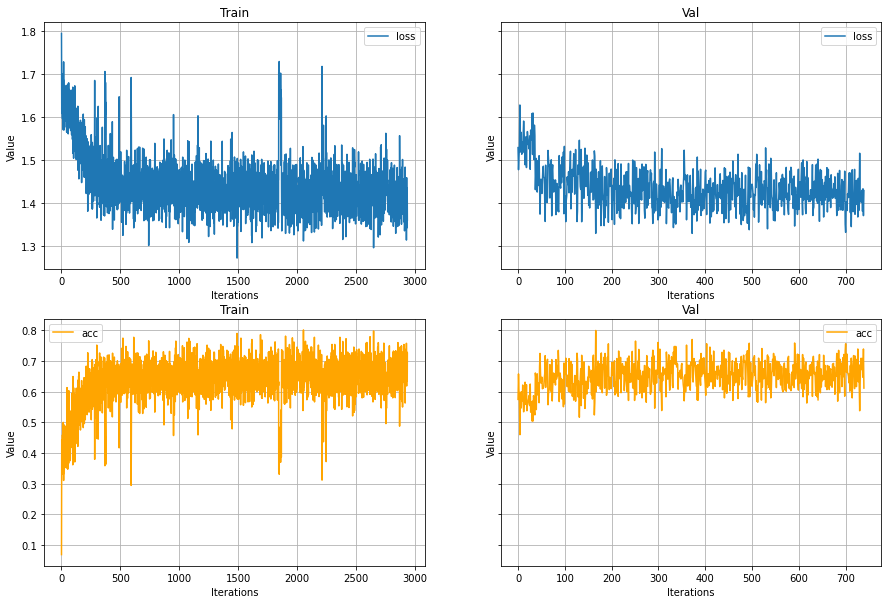

{'filter_sizes': [2, 3, 4], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5847525191144878, Train metric: 0.4954898953437805
Val loss: 1.5414045308087323, Val metric: 0.5455091595649719
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5383939013189198, Train metric: 0.5460063815116882
Val loss: 1.5306731720228453, Val metric: 0.5446838140487671
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4990265101802593, Train metric: 0.5863946676254272
Val loss: 1.452472979957993, Val metric: 0.6322515606880188
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.44580137324171, Train metric: 0.6385515928268433
Val loss: 1.4280056856773995, Val metric: 0.6577989459037781
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4340962447276733, Train metric: 0.6497531533241272
Val loss: 1.4254977928625572, Val metric: 0.6592403054237366
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4280160422227821, Train metric: 0.6544186472892761
Val loss: 1.4199927948616646, Val metric: 0.66434

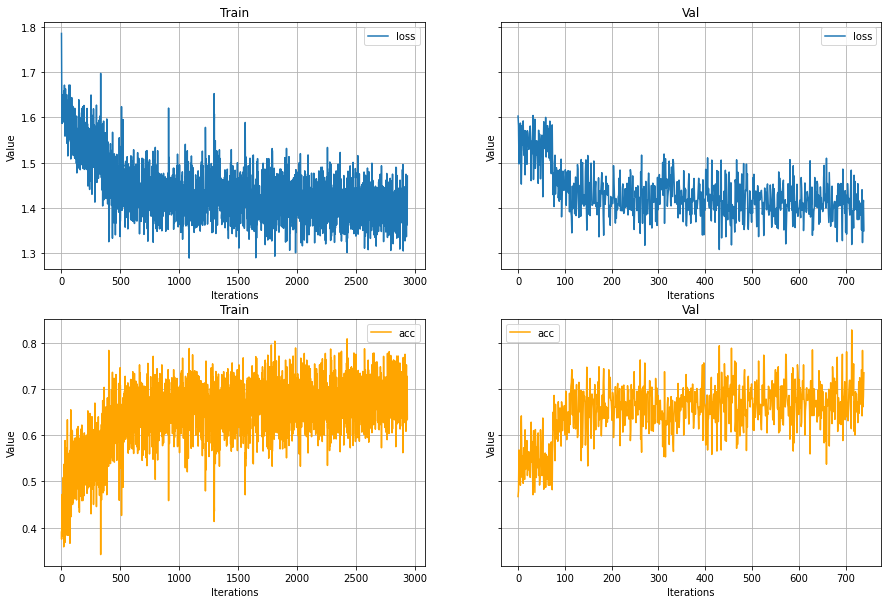

{'filter_sizes': [2, 3, 4], 'num_filters': 150, 'memory_dim': 150, 'lstm_layers': 1, 'dropout_layer': ['emb', 'lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.634296060419407, Train metric: 0.41370251774787903
Val loss: 1.6249941877416663, Val metric: 0.42741045355796814
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.4940225429275409, Train metric: 0.6022200584411621
Val loss: 1.4394578547091097, Val metric: 0.6461470723152161
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4383037325476302, Train metric: 0.647554874420166
Val loss: 1.4432902464995514, Val metric: 0.6425420045852661
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4347105861521092, Train metric: 0.650190532207489
Val loss: 1.6548841772852718, Val metric: 0.41597771644592285
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4744725389545466, Train metric: 0.610353946685791
Val loss: 1.4462173629451442, Val metric: 0.6409003734588623
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4476655437832786, Train metric: 0.6380437612533569
Val loss: 1.441053928555669, Val metric: 0.6417

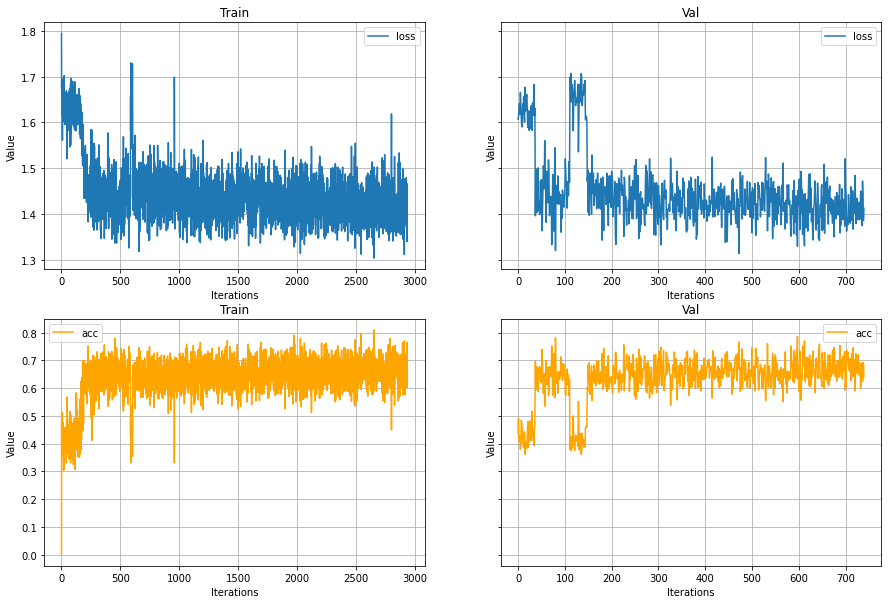

{'filter_sizes': [2, 3, 4], 'num_filters': 150, 'memory_dim': 300, 'lstm_layers': 1, 'dropout_layer': ['emb']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.6372304700669789, Train metric: 0.4175862967967987
Val loss: 1.655591420225195, Val metric: 0.4155912399291992
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5847294549552762, Train metric: 0.49750471115112305
Val loss: 1.5286837719582222, Val metric: 0.5525142550468445
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5350914585347077, Train metric: 0.5449491143226624
Val loss: 1.5189143612578109, Val metric: 0.5624024271965027
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.528153767391127, Train metric: 0.5516522526741028
Val loss: 1.518868597778114, Val metric: 0.5616762042045593
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5242264084264534, Train metric: 0.555461049079895
Val loss: 1.5146071137608708, Val metric: 0.5622336864471436
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.5192530868815728, Train metric: 0.5582799315452576
Val loss: 1.5053136058755823, Val metric: 0.57555

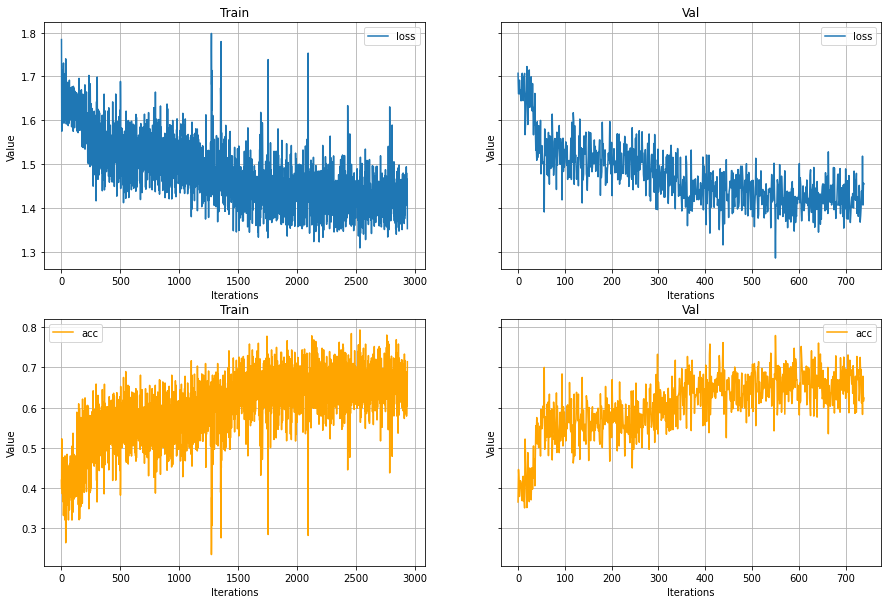

{'filter_sizes': [2, 3, 4], 'num_filters': 150, 'memory_dim': 300, 'lstm_layers': 1, 'dropout_layer': ['lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.620469519881164, Train metric: 0.4459802508354187
Val loss: 1.574812380043236, Val metric: 0.552571177482605
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5407202016739618, Train metric: 0.5421788096427917
Val loss: 1.5279826795732654, Val metric: 0.5576362013816833
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5301813171023415, Train metric: 0.5493450164794922
Val loss: 1.5439177977072227, Val metric: 0.5261802673339844
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5212073909993074, Train metric: 0.5581417083740234
Val loss: 1.500994650093285, Val metric: 0.5853025913238525
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4762662608607287, Train metric: 0.6070020198822021
Val loss: 1.4460983727429364, Val metric: 0.636247992515564
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.4435775661144128, Train metric: 0.6390460133552551
Val loss: 1.4370980069443986, Val metric: 0.6452692

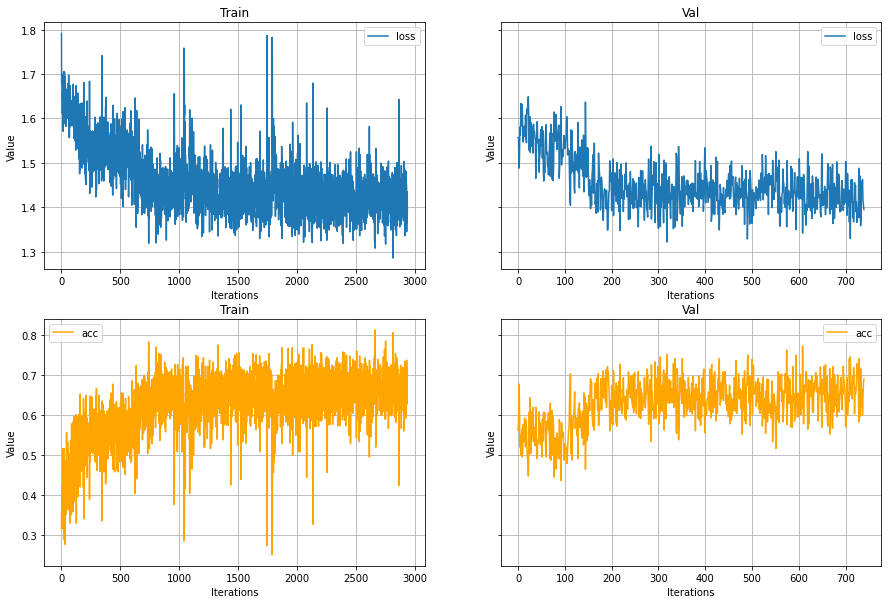

{'filter_sizes': [2, 3, 4], 'num_filters': 150, 'memory_dim': 300, 'lstm_layers': 1, 'dropout_layer': ['emb', 'lstm']}
Training...


  0%|          | 0/20 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.603095556602997, Train metric: 0.4759315848350525
Val loss: 1.5712559738674678, Val metric: 0.5080481767654419
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.545275940376074, Train metric: 0.5353924036026001
Val loss: 1.532874500429308, Val metric: 0.5445744395256042
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.5394497842204815, Train metric: 0.5401955842971802
Val loss: 1.5915925341683466, Val metric: 0.48211488127708435
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.5443943390229933, Train metric: 0.5326708555221558
Val loss: 1.5229941638740334, Val metric: 0.5642503499984741
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.5262429689874455, Train metric: 0.5523436665534973
Val loss: 1.5120605584737417, Val metric: 0.5664100646972656
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.519697129320936, Train metric: 0.5569528341293335
Val loss: 1.4935797259614274, Val metric: 0.58976

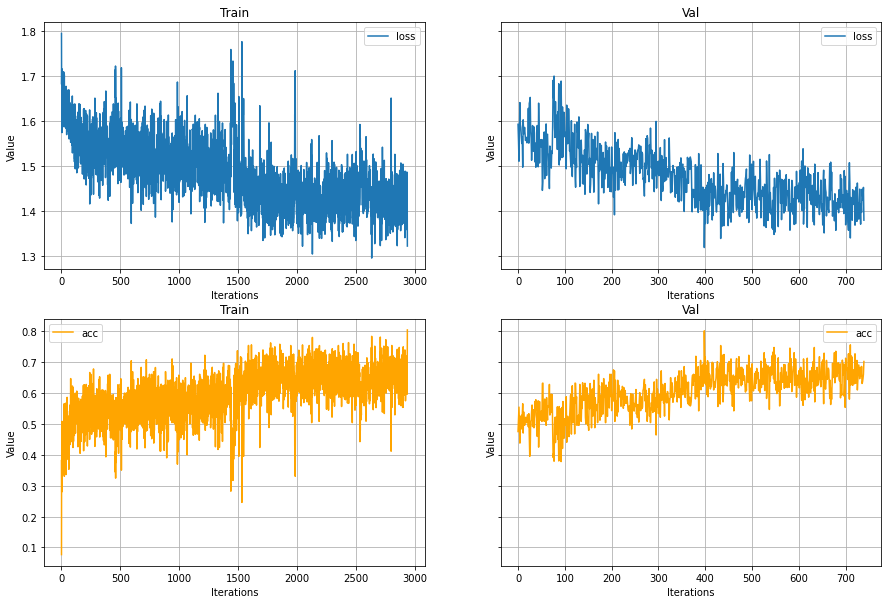

In [ ]:
for filter_sizes in [[2], [2, 3, 4]]:
    for memory_dim in [100, 150, 300]:
        for dropout_layer in [['emb'], ['lstm'], ['emb', 'lstm']]:
            num_filters = 150 
            lstm_layers = 1  
            model = CLSTM(len(word2id),
                          num_filters=num_filters,
                          memory_dim=memory_dim,
                          lstm_layers=lstm_layers, 
                          dropout_layer=dropout_layer,
                          filter_sizes=filter_sizes)
            optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
            criterion = nn.CrossEntropyLoss()

            print({'filter_sizes': filter_sizes,
                    'num_filters': num_filters,
                    'memory_dim': memory_dim,
                    'lstm_layers': lstm_layers,
                    'dropout_layer': dropout_layer})

            out = train(train_iterator,
                        val_iterator,
                        model,
                        optimizer,
                        criterion,
                        epochs=20,
                        metric=accuracy)

            results.append({'filter_sizes': filter_sizes,
                            'num_filters': num_filters,
                            'memory_dim': memory_dim,
                            'lstm_layers': lstm_layers,
                            'dropout_layer': dropout_layer,
                            'accuracy': out[-1]})

            plot_training(*out)
            plt.show()

In [ ]:
sorted(results, key=lambda x: x['accuracy'], reverse=True)[0]

{'filter_sizes': [2, 3, 4],
 'num_filters': 150,
 'memory_dim': 150,
 'lstm_layers': 1,
 'dropout_layer': ['lstm'],
 'accuracy': 0.6843055}

Как видим лучшее качество получила модель с параметрами из статьи (если я правильно помню, уже прошло много времени...)
Добавим эпох!

Training...


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1:
Train loss: 1.5853906983420962, Train metric: 0.48941075801849365
Val loss: 1.5361999853237256, Val metric: 0.54313063621521
* * * * * * * * * * * * * * * * * * * * 
Epoch 2:
Train loss: 1.5294898780835728, Train metric: 0.550396740436554
Val loss: 1.5094690902813062, Val metric: 0.5770909786224365
* * * * * * * * * * * * * * * * * * * * 
Epoch 3:
Train loss: 1.4739505303960267, Train metric: 0.6092866659164429
Val loss: 1.4410775835449632, Val metric: 0.6413436532020569
* * * * * * * * * * * * * * * * * * * * 
Epoch 4:
Train loss: 1.4373294885466699, Train metric: 0.6465023756027222
Val loss: 1.4437444532239758, Val metric: 0.6396105289459229
* * * * * * * * * * * * * * * * * * * * 
Epoch 5:
Train loss: 1.4344365783289177, Train metric: 0.6484926342964172
Val loss: 1.4306270206296765, Val metric: 0.6549593210220337
* * * * * * * * * * * * * * * * * * * * 
Epoch 6:
Train loss: 1.5412256523054473, Train metric: 0.5307644605636597
Val loss: 1.590444429500683, Val metric: 0.52780

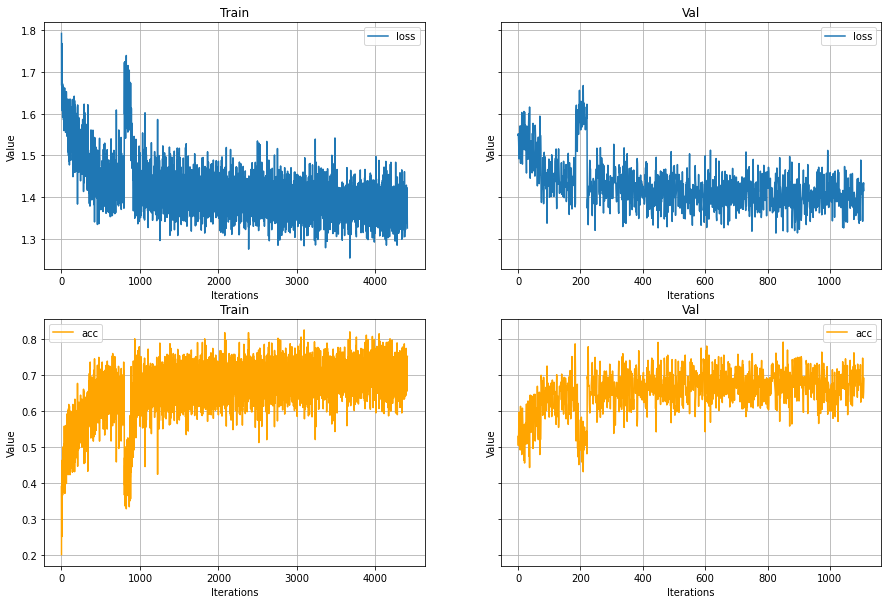

In [ ]:
model = CLSTM(len(word2id),
              num_filters=150,
              memory_dim=150,
              lstm_layers=1, 
              dropout_layer=['lstm'],
              filter_sizes=[2,3,4])

optimizer = torch.optim.RMSprop(model.parameters(), lr=0.001, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()

out = train(train_iterator,
            val_iterator,
            model,
            optimizer,
            criterion,
            epochs=30,
            metric=accuracy)

plot_training(*out)
plt.show()

## Итоги

Мы протестировали разные гиперпараметры для нашей модели и выяснили, что лучше всего на наших данных справляется модель с параметрами 
```
filter_sizes: [2, 3, 4]
num_filters: 150
memory_dim: 150
lstm_layers: 1
dropout_layer: ['lstm']
epochs=10
```

Теперь по отдельным конфигурациям: 

1. Надо отметить, что дропаут после слоя эмбеддингов не сильно влияет на обучение, а дропаут после выхода из lstm бустит качество (что вижно на итоговых экспериментах)

2. С дропаутом после слоя эмбеддингов, соответственно, модель лучшее качество выдает при наличии одного фильтра размера 2, в остальных случаях переобучается. С дропаутом после lstm -- можем позволить себе больше фичей и фильтры 2,3,4. 

3. Внутренняя размерность lstm слоя и количество применяемых фильтров (num_filters) лучше всего 150, при этом при уменьшении этого количества приходим к недообучению, при увеличении -- становимся близки к переобучению / выходу в плато

4. Самое оптимальное количество слоем lstm модели -- 1.

С итоговой конфигурацией и увеличением числа эпох получили качество 0.6843055. Предположительно можно еще увеличить эпох и станет лучше, т.к. learning curve выглядит оптимистично)

В целом, стоит сказать, что результаты не очень хорошие, но кажется, что наши данные довольно несбалансированные, нужно проанализировать матрицу ошибок, предполагаю, что модель плохо справляется с маленькими классами. 


Еще в статье не указано, но на наших данных дальше наверное стоит провести эксперименты с lr и scheduler'ом